In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import gillespie as gp
import statistics as st
import seaborn as sns
import networkx as nx
import pandas as pd

import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.bokeh.MultiPlot import MultiPlot

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot, column

from mpl_toolkits.mplot3d import Axes3D

# pip install ndlib
# pip install networkx==3.3
# pip install ndlib==5.1.0
# pip install bokeh==2.3.3


AttributeError: module 'numpy' has no attribute 'bool8'

# Implement Gillespie's algorithm

Gillespie's Algorithm (Stochastic SIR Model)

In [2]:
beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 990
Y0 = 1
Z0 = 0

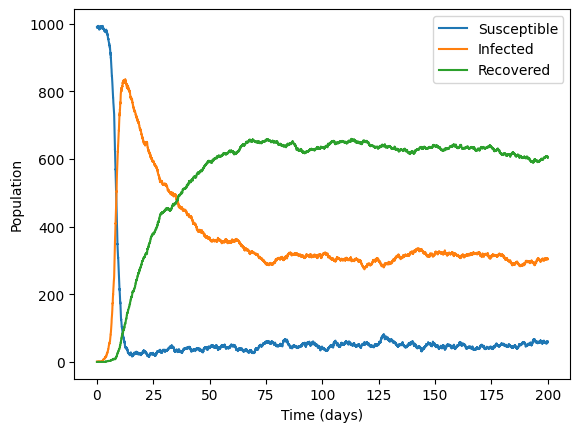

In [3]:
def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    X = [X0]
    Y = [Y0]
    Z = [Z0]
    t = [0]

    R0_stoch = beta / (mu + gamma)

    # Gillespie algorithm loop
    while t[-1] < tend:
        current_X = X[-1]
        current_Y = Y[-1]
        current_Z = Z[-1]
        
        # If there are no susceptible and infected, break out of the loop (epidemic is over)
        if current_Y == 0 and current_X == 0:
            break

        # Rates for all possible events
        birth_rate = mu * N
        infection_rate = beta * current_X * current_Y / N
        recovery_rate = gamma * current_Y
        death_susc_rate = mu * current_X
        death_inf_rate = mu * current_Y
        death_recov_rate = mu * current_Z

        rates = [birth_rate, infection_rate, recovery_rate,
                 death_susc_rate, death_inf_rate, death_recov_rate]
        rate_sum = sum(rates)

        # If rate_sum is zero, no more events are possible
        if rate_sum <= 0:
            break  # End the simulation

        # Time until next event (exponentially distributed)
        tau = np.random.exponential(scale=1/rate_sum)
        t.append(t[-1] + tau)

        rand = random.uniform(0, rate_sum)
        cum_rate = 0

        # Determine which event happens next
        if rand < (cum_rate := cum_rate + birth_rate): # Birth
            current_X += 1
        
        elif rand < (cum_rate := cum_rate + infection_rate) and current_X > 0: # Infection
            current_X -= 1
            current_Y += 1
        
        elif rand < (cum_rate := cum_rate + recovery_rate) and current_Y > 0: # Recovery
            current_Y -= 1
            current_Z += 1

        elif rand < (cum_rate := cum_rate + death_susc_rate):  # Death of susceptible
            current_X -= 1

        elif rand < (cum_rate := cum_rate + death_inf_rate):  # Death of infected
            current_Y -= 1

        elif rand < (cum_rate := cum_rate + death_recov_rate): # Death of recovered
                current_Z -= 1

        X.append(current_X)
        Y.append(current_Y)
        Z.append(current_Z)

    return X, Y, Z, t, R0_stoch

tend = 200 # simulation time (200 days)
seed = 42

Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

# Plot the results
plt.plot(t, Xs, label="Susceptible")
plt.plot(t, Ys, label="Infected")
plt.plot(t, Zs, label="Recovered")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.show()

Deterministic SIR Model

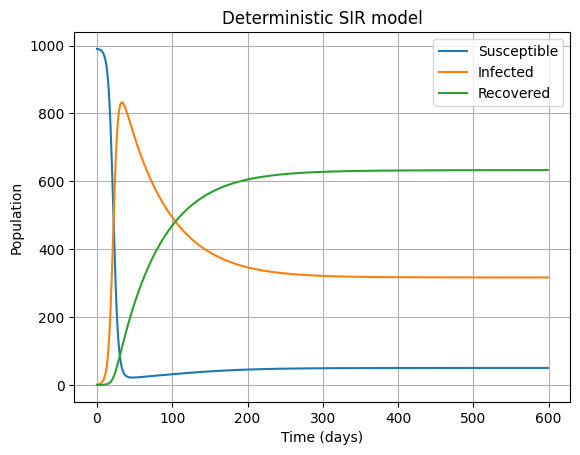

In [4]:
start_t = 0
end_t = 200
points_t = 600
init_val = [X0, Y0, Z0]

# Defining the deterministic ODEs
def SIR(val, t, beta, gamma, mu, N): 
    X, Y, Z = val

    dXdt = mu * N - beta * X * Y / N - mu * X 
    dYdt = beta * X * Y / N - gamma * Y - mu * Y 
    dZdt = gamma * Y - mu * Z 
    
    return np.array([dXdt, dYdt, dZdt])

# Solving the deterministic SIR model
def deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t):

    R0_det = beta / (mu + gamma)

    time = np.linspace(start_t, end_t, points_t)
    init_val = [X0, Y0, Z0]
    solution = odeint(SIR, init_val, time, args=(beta, gamma, mu, N))
    Xd, Yd, Zd = solution.T

    return Xd, Yd, Zd, time, R0_det

Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

plt.plot(Xd, label="Susceptible")
plt.plot(Yd, label="Infected")
plt.plot(Zd, label = "Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("Deterministic SIR model")
plt.legend()
plt.grid()
plt.show()


Plotting Deterministic and Stochastic SIR

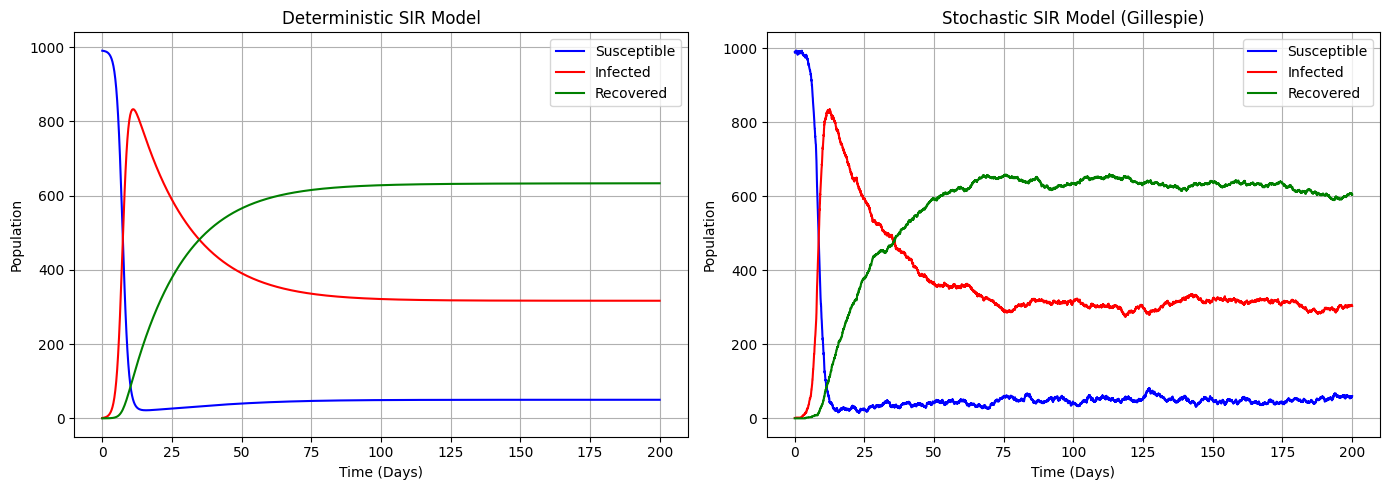

In [5]:
# Solving the deterministic model
Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
# Solving the stochastic model using Gillespie algorithm
Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(time, Xd, label="Susceptible", color='blue')
ax1.plot(time, Yd, label="Infected", color='red')
ax1.plot(time, Zd, label="Recovered", color='green')
ax1.set_title("Deterministic SIR Model")
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Population")
ax1.legend(loc="best")
ax1.grid(True)

ax2.plot(t, Xs, label="Susceptible", color='blue')
ax2.plot(t, Ys, label="Infected", color='red')
ax2.plot(t, Zs, label="Recovered", color='green')
ax2.set_title("Stochastic SIR Model (Gillespie)")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Population")
ax2.legend(loc="best")
ax2.grid(True)

plt.tight_layout()
plt.show()

Function to run multiple simulations of stochastic SIR (and return mean and variance of X, Y, Z)

Number of simulations: 50
Mean of Susceptibles: 142.87121439027328
Variance of Susceptibles: 75564.21680862013
Mean of Infected: 280.53527589860664
Variance of Infected: 9042.127827824197


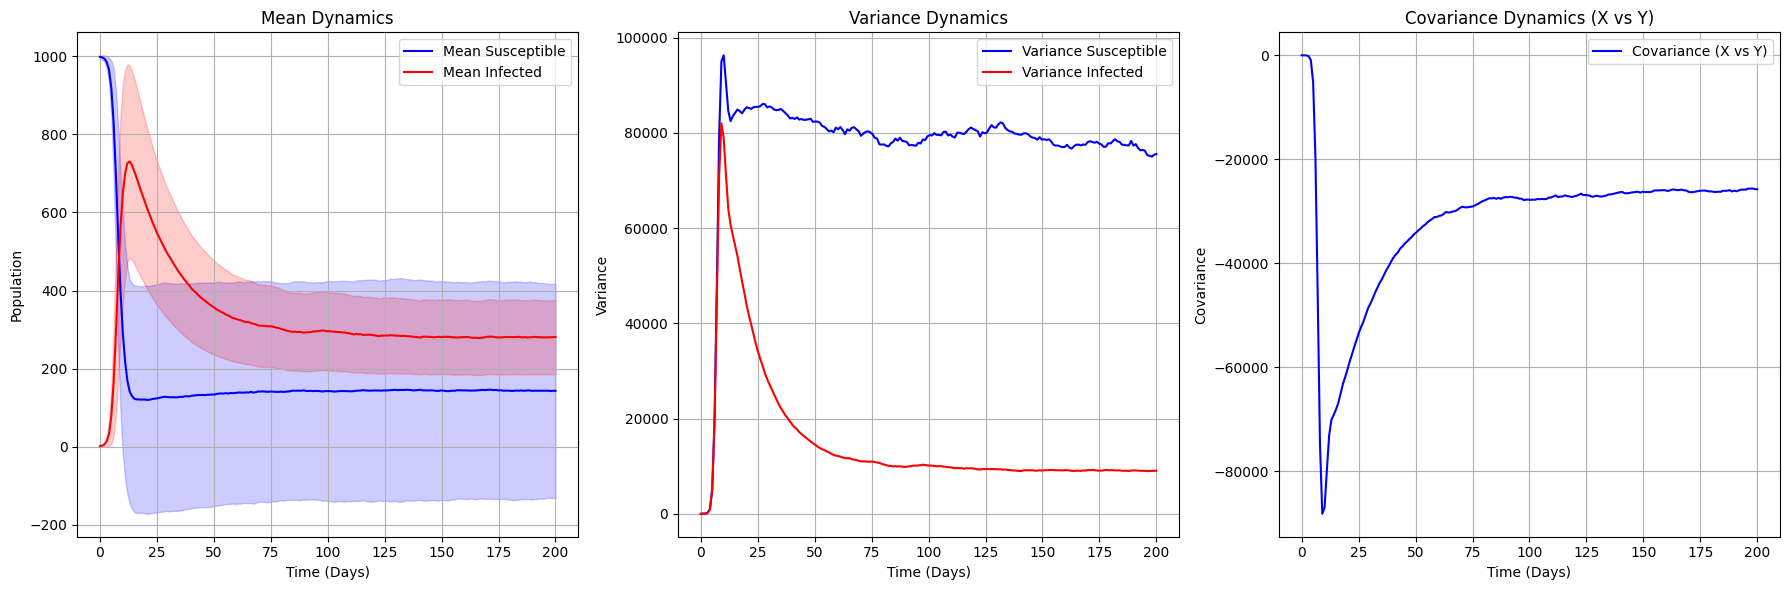

In [6]:
def run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed):
    # Accumulating Xs, Ys, Zs across simulations
    all_Xs = [] 
    all_Ys = []  
    all_Zs = []
    cov_array = np.zeros(tend)

    time_p = np.linspace(0, tend, 200) # 200 time points

    for i in range(sims):
        # Run Gillespie simulation for current iteration
        Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend)

        # Interpolate to have consistent time points
        X_interp = np.interp(time_p, t, Xs)
        Y_interp = np.interp(time_p, t, Ys)
        Z_interp = np.interp(time_p, t, Zs)

        all_Xs.append(X_interp)
        all_Ys.append(Y_interp)
        all_Zs.append(Z_interp)

    all_Xs = np.array(all_Xs)
    all_Ys = np.array(all_Ys)
    all_Zs = np.array(all_Zs)

    # Average population size of each compartment at each time point
    mean_Xs = np.mean(all_Xs, axis = 0)
    mean_Ys = np.mean(all_Ys, axis = 0)
    mean_Zs = np.mean(all_Zs, axis = 0)

    # Variability of population sizes across simulations
    var_Xs = np.var(all_Xs, axis = 0)
    var_Ys = np.var(all_Ys, axis = 0)
    var_Zs = np.var(all_Zs, axis = 0)

    return time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys

# Computing covariance between S and I
def covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend):
    cov_Xs_Ys = np.zeros(tend)
    for t in range(tend):
        cov_Xs_Ys[t] = np.mean((all_Xs[:, t] - mean_Xs[t]) * (all_Ys[:, t] - mean_Ys[t]))
    return cov_Xs_Ys

sims = 50
X0 = 999
Y0 = 1
Z0 = 0
beta = 1
gamma = 1/30
mu = 1/60
N = X0 + Y0 + Z0
tend = 200

# Run the stochastic simulations
time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)
cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend)

print(f"Number of simulations: {sims}")
print(f"Mean of Susceptibles: {mean_Xs[-1]}")
print(f"Variance of Susceptibles: {var_Xs[-1]}")
print(f"Mean of Infected: {mean_Ys[-1]}")
print(f"Variance of Infected: {var_Ys[-1]}")

# Plotting the mean, variance and covariance (X vs Y)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

std_Xs = np.std(all_Xs, axis=0)
std_Ys = np.std(all_Ys, axis=0)

axes[0].plot(time_p, mean_Xs, label='Mean Susceptible', color='blue')
axes[0].plot(time_p, mean_Ys, label='Mean Infected', color='red')
axes[0].fill_between(time_p, mean_Xs - std_Xs, mean_Xs + std_Xs, color='blue', alpha=0.2)
axes[0].fill_between(time_p, mean_Ys - std_Ys, mean_Ys + std_Ys, color='red', alpha=0.2)
axes[0].set_title("Mean Dynamics")
axes[0].set_xlabel("Time (Days)")
axes[0].set_ylabel("Population")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(time_p, var_Xs, label='Variance Susceptible', color='blue')
axes[1].plot(time_p, var_Ys, label='Variance Infected', color='red')
axes[1].set_title("Variance Dynamics")
axes[1].set_xlabel("Time (Days)")
axes[1].set_ylabel("Variance")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(time_p, cov_Xs_Ys, label='Covariance (X vs Y)', color='blue')
axes[2].set_title("Covariance Dynamics (X vs Y)")
axes[2].set_xlabel("Time (Days)")
axes[2].set_ylabel("Covariance")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Investigate Simulation Variability and Negative Co-variance

In [42]:
# Fixed parameters
N = 1000
beta = 1
gamma = 1/3
mu = 1/60
sims = 5

Varying N

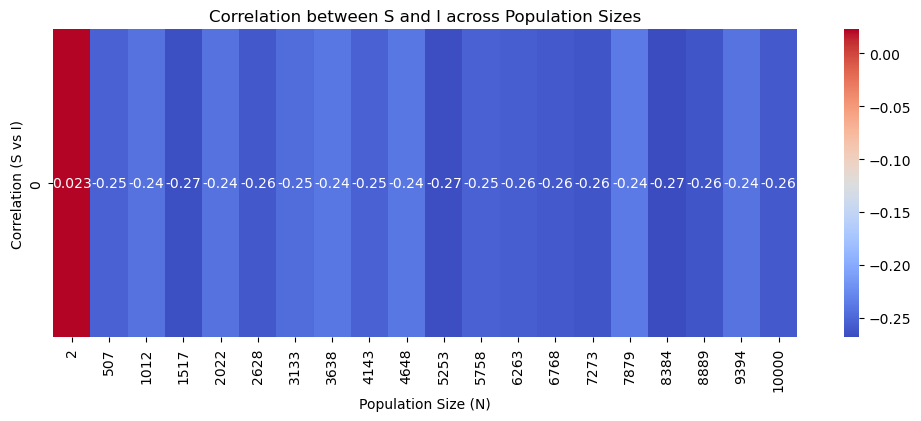

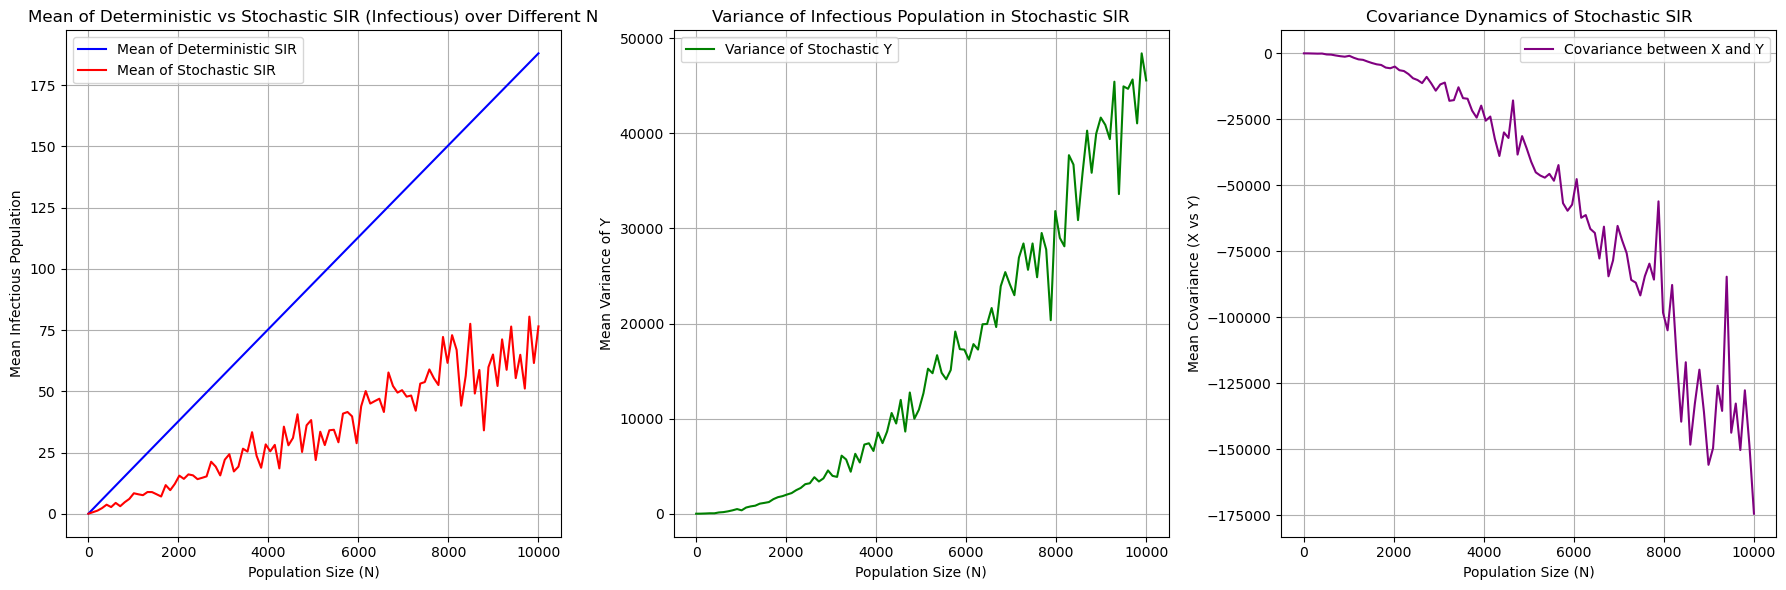

([0.04101415309480043,
  1.9437493873984744,
  3.8588122340327455,
  5.771164115021081,
  7.681774927836265,
  9.591101247586296,
  11.49940990507851,
  13.406876407425111,
  15.31362489506531,
  17.219747898220547,
  19.125317023361575,
  21.030389068189024,
  22.935010625655472,
  24.839220184988157,
  26.743050342590813,
  28.64652861801785,
  30.54967973595888,
  32.452523668649995,
  34.355079865746546,
  36.2573644434581,
  38.15939205036108,
  40.061175334844236,
  41.96272719540476,
  43.86405748680792,
  45.765176977103195,
  47.66609439419674,
  49.56681721252253,
  51.46735410721769,
  53.367711941370686,
  55.267896830708494,
  57.16791497767663,
  59.06777290472075,
  60.967474689581366,
  62.867025947509184,
  64.76643130684376,
  66.6656955038141,
  68.56482242684817,
  70.46381539015177,
  72.36267865829785,
  74.26141581483387,
  76.1600297266769,
  78.05852388276125,
  79.95690143182875,
  81.8551648628696,
  83.75331687695933,
  85.6513602508021,
  87.549297630441,
 

In [204]:

def diff_params_N(N_diff, sims, beta, gamma, mu):
    
    mean_deter = []  # Means from the deterministic model
    mean_stoch = []  # Means from the stochastic model
    var_Y = []       # Variances of Y
    cov_XY = []      # Covariances between X and Y
    correlations = []  # Correlations between X and Y

    # Iterate through different population sizes
    for n in np.nditer(N_diff):
        X0 = int(n) - 1   # Initial susceptible population
        Y0 = 1            # Initial infected population
        Z0 = 0            # Initial recovered population
        
        # Run stochastic and deterministic simulations for the current population size
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, int(n), tend=200)
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, int(n), beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append final mean for deterministic and stochastic model
        mean_deter.append(np.mean(Yd))  
        mean_stoch.append(np.mean(mean_Ys))

        # Append final variance of stochastic model
        var_Y.append(np.mean(var_Ys)) 

        # Calculate and append final covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

        # Calculate the correlation between X and Y
        correlation_si = np.corrcoef(all_Xs.flatten(), all_Ys.flatten())[0, 1]  # Correlation coefficient between S and I
        correlations.append(correlation_si)
        
    # Reduce the number of population sizes shown in the heatmap
    selected_indices = np.linspace(0, len(N_diff) - 1, 20).astype(int)  # Select 20 population sizes to display
    N_diff_selected = N_diff[selected_indices]
    correlations_selected = np.array(correlations)[selected_indices]

    # Create a heatmap of the correlation between X and Y across population sizes
    plt.figure(figsize=(12, 4))
    sns.heatmap(np.array(correlations_selected).reshape(1, -1), annot=True, cmap='coolwarm', xticklabels=np.round(N_diff_selected).astype(int))
    plt.title("Correlation between S and I across Population Sizes")
    plt.xlabel("Population Size (N)")
    plt.ylabel("Correlation (S vs I)")
    plt.show()

    # Initialize the other plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(N_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(N_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different N")
    axes[0].set_xlabel("Population Size (N)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(N_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over N
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Population Size (N)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(N_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over N
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Population Size (N)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()


    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY , time_p, all_Ys

# Example usage
N_diff = np.linspace(2, 10000, 100)  # Different values of population
sims = 20  # Number of stochastic simulations
beta = 1.5
gamma = 0.5
mu = 0.01

diff_params_N(N_diff, sims, beta, gamma, mu)


Varying Y0 (initial number of infectious individuals)

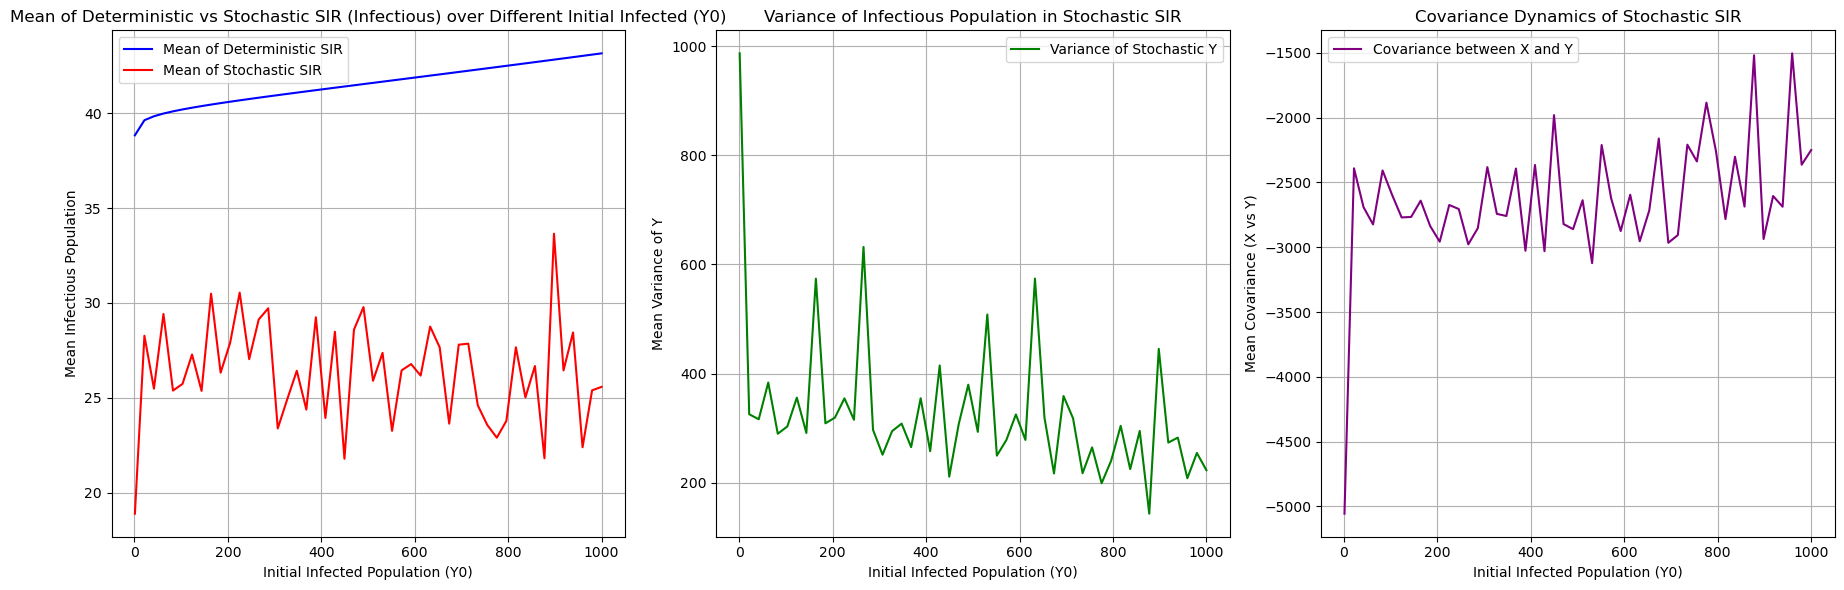

([38.836618732812255,
  39.63116133442313,
  39.84053162528243,
  39.98374290716619,
  40.09948752163034,
  40.200199370773625,
  40.291479750915926,
  40.37633660746935,
  40.456573876521034,
  40.53335889743301,
  40.607491661596576,
  40.67954370025737,
  40.74993791896634,
  40.81899629113971,
  40.886969517653334,
  40.95405606194825,
  41.02041676813486,
  41.08618273514102,
  41.151462625185076,
  41.21634738403902,
  41.280914240553976,
  41.34522805955743,
  41.40934512138925,
  41.4733139159554,
  41.53717566322648,
  41.60096757803633,
  41.664720862068336,
  41.728463804889195,
  41.79222062141197,
  41.856013484242915,
  41.9198612105267,
  41.98378041510839,
  42.04778649724189,
  42.111892277549714,
  42.1761101301428,
  42.240449950327175,
  42.30492102783117,
  42.36953181928078,
  42.434289379840955,
  42.49920004816255,
  42.56426967989324,
  42.629502665985555,
  42.69490426362577,
  42.76047762054066,
  42.82622620634265,
  42.892152866603794,
  42.95825998542328,


In [208]:
Y0_diff = np.linspace(1, 1000, 50)

def diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different initial infected populations Y0
    for y0 in Y0_diff:
        X0 = N - y0  # Initial susceptible population
        Y0 = y0      # Initial infected population
        Z0 = 0       # Initial recovered population
        
        # Run stochastic simulations for the current population size
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current population size
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(Y0_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(Y0_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Initial Infected (Y0)")
    axes[0].set_xlabel("Initial Infected Population (Y0)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(Y0_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over Y0
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Initial Infected Population (Y0)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(Y0_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over Y0
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Initial Infected Population (Y0)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY
N = 1000
beta = 1
gamma = 1/3
mu = 1/60
sims = 20


diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu)


Varying beta (transmission rate)

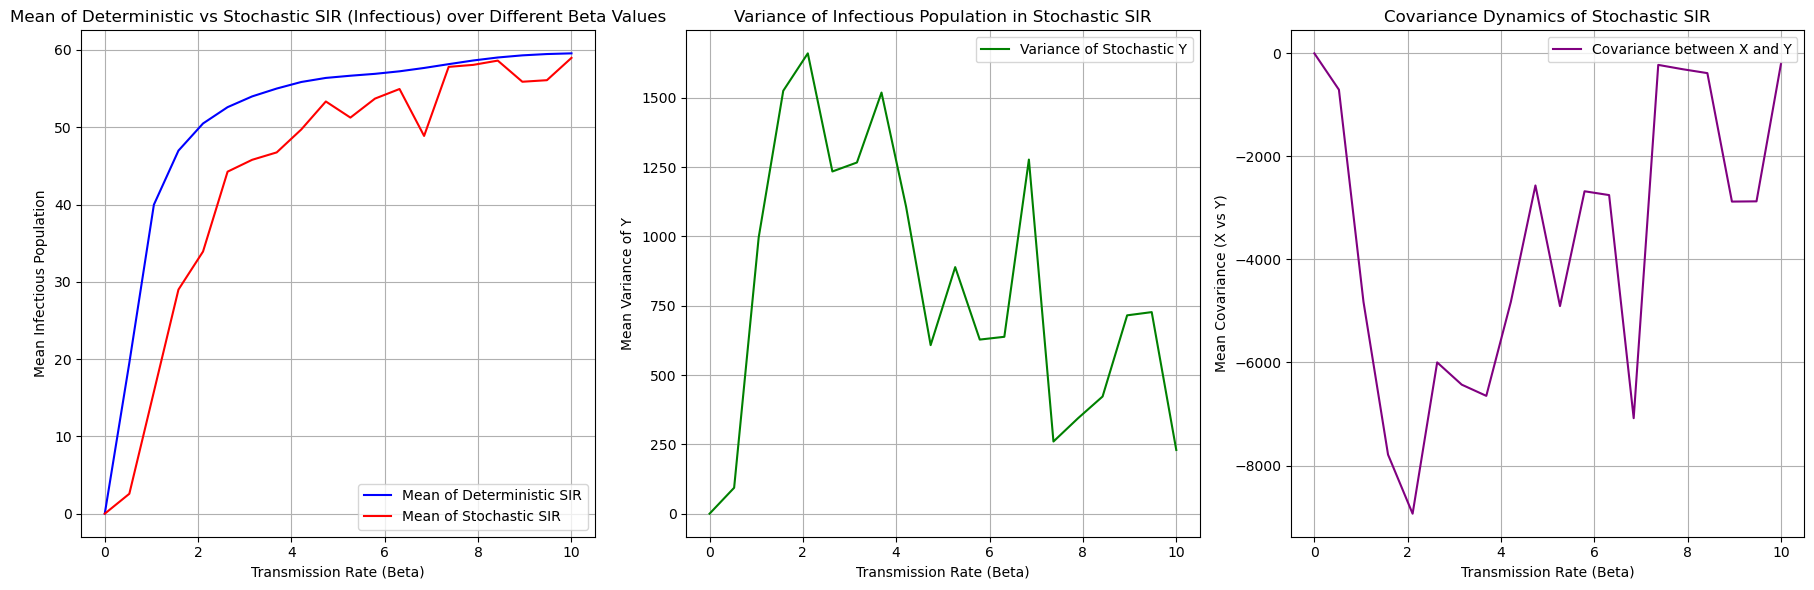

([0.016860548643746892,
  19.520508208678788,
  39.97622692482012,
  46.96913457965733,
  50.47783144706309,
  52.58854013625409,
  53.98002394788929,
  54.99573066330505,
  55.84435192080029,
  56.37011679313897,
  56.65369879794466,
  56.89831702866941,
  57.22524883226131,
  57.65831527768988,
  58.151007622038996,
  58.624472729987566,
  59.01247075557734,
  59.28772964427886,
  59.45796142755931,
  59.54744584981872],
 [0.014080806828062023,
  2.5913428490957853,
  15.788978452884942,
  28.997611650893024,
  33.917081241529026,
  44.24695575323612,
  45.78130056144388,
  46.739261805836165,
  49.70279873414018,
  53.32362917367711,
  51.23867004021071,
  53.69430982473143,
  54.93608513453453,
  48.867767652443,
  57.79943934483744,
  58.057691011922905,
  58.60784730669252,
  55.8752244735462,
  56.07662656588094,
  58.96322228013316],
 [0.004685608735147809,
  93.49324093373738,
  996.2155104286497,
  1525.0133270862127,
  1660.0226422614173,
  1234.0474641636354,
  1266.4512432

In [209]:
beta_diff = np.linspace(0, 10, 20)

def diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different beta values
    for beta in beta_diff:
        
        # Run stochastic simulations for the current beta
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current beta
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(beta_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(beta_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Beta Values")
    axes[0].set_xlabel("Transmission Rate (Beta)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(beta_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over beta
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Transmission Rate (Beta)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(beta_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over beta
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Transmission Rate (Beta)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY, time_p, all_Ys

N = 1000
gamma = 1/3
mu = 1/60
X0 = 999
Y0 = 1
Z0 = 0
sims = 20

# Call the function with fixed parameters and varying beta
diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0)

Varying gamma (rate of recovery)

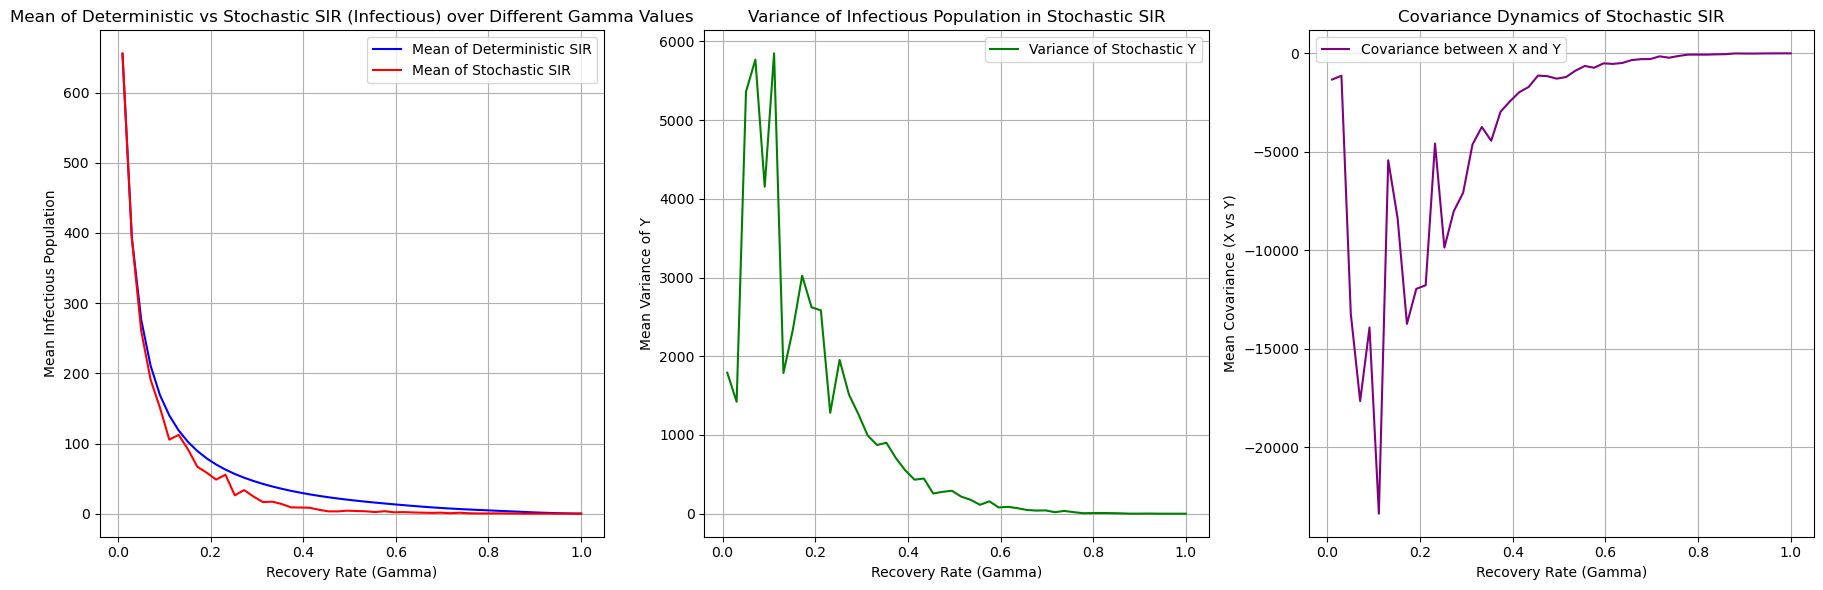

([654.6045902253433,
  392.9605012103251,
  276.50465147477263,
  211.04694104514604,
  169.15498388829693,
  140.0546062159223,
  118.66587189818335,
  102.28304010895688,
  89.33336447447581,
  78.84044653429304,
  70.16601481204788,
  62.87496595499955,
  56.660062511879566,
  51.29773177006711,
  46.62118363554149,
  42.503720185628545,
  38.84823570866696,
  35.580413413030996,
  32.64386529118687,
  29.995960215599872,
  27.603650572210892,
  25.43937586577802,
  23.47774767933977,
  21.69372394475874,
  20.06230561724892,
  18.55914335337294,
  17.16131917134612,
  15.84796524754437,
  14.60088706959225,
  13.405724820330152,
  12.25418845921648,
  11.147039710229363,
  10.095394108981514,
  9.116531858701983,
  8.224154230328338,
  7.420142886452947,
  6.694365276232995,
  6.030353792607238,
  5.4106578758297,
  4.819028469710273,
  4.240166771163583,
  3.659199377880114,
  3.065109992690186,
  2.4649899530938693,
  1.899038630487579,
  1.4095444304690878,
  0.990998618261185,


In [212]:
gamma_diff = np.linspace(0.01, 1, 50)


def diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different gamma values
    for gamma in gamma_diff:

        # Run stochastic simulations for the current gamma
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current gamma
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(gamma_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(gamma_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Gamma Values")
    axes[0].set_xlabel("Recovery Rate (Gamma)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(gamma_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over gamma
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Recovery Rate (Gamma)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(gamma_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over gamma
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Recovery Rate (Gamma)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY, time_p, all_Ys

N = 1000
beta = 1
mu = 1/60
X0 = 999
Y0 = 1
Z0 = 0
sims = 20

# Call the function with fixed parameters and varying gamma
diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0)

Varying mu (birth rate)

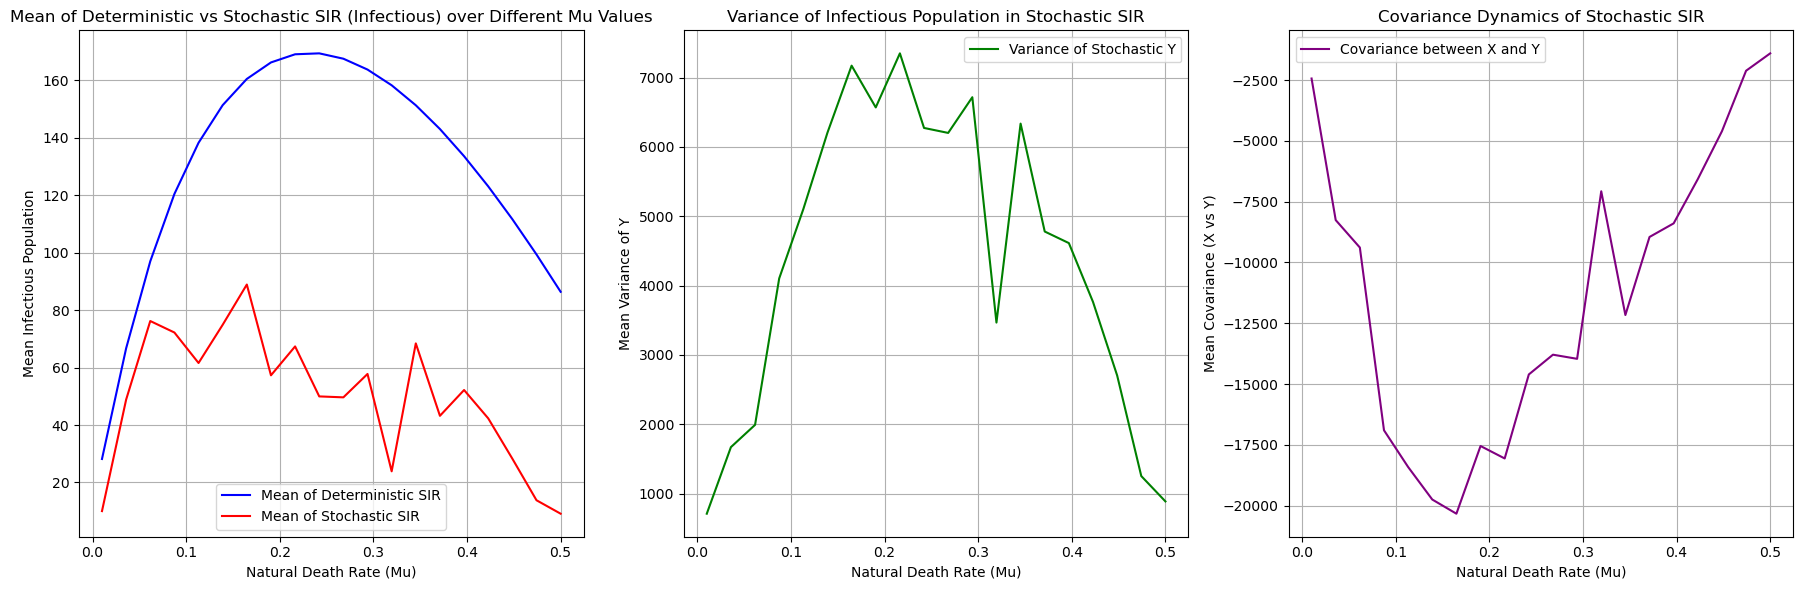

([28.173931733459984,
  66.71253723192292,
  97.02485419227122,
  120.48502774248715,
  138.30294738154325,
  151.41098452035004,
  160.5441782475685,
  166.2914370279126,
  169.1308325269526,
  169.45489798495507,
  167.58922800956577,
  163.80642431750147,
  158.33673122223368,
  151.37627960239598,
  143.09357693636582,
  133.63473305793894,
  123.12777321880264,
  111.68636476525508,
  99.41327575869525,
  86.4039977370815],
 [10.02118498276631,
  48.84353107470484,
  76.22310317232537,
  72.22126017931274,
  61.605820467485664,
  74.92185856219014,
  88.92929037166519,
  57.31396436797257,
  67.37753629171802,
  49.96710596239518,
  49.640415746783276,
  57.7871315864692,
  23.8738893531536,
  68.43277901001103,
  43.20842772097883,
  52.19311668268109,
  42.32274068239281,
  28.27415530091487,
  13.798810395719299,
  9.113364503956532],
 [708.6781003318386,
  1669.1017891646604,
  1990.301951693585,
  4103.094790132517,
  5103.282057692715,
  6206.415329545457,
  7172.48580315906

In [213]:
mu_diff = np.linspace(0.01, 0.5, 20)

def diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different mu values
    for mu in mu_diff:
        # Run stochastic simulations for the current mu
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current mu
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(mu_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(mu_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Mu Values")
    axes[0].set_xlabel("Natural Death Rate (Mu)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(mu_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over mu
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Natural Death Rate (Mu)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(mu_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over mu
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Natural Death Rate (Mu)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

N = 1000
beta = 1
gamma = 1/3
X0 = 999
Y0 = 1
Z0 = 0
sims = 20

# Call the function with varying mu
diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0)

# Stochastic Resonance and Increased Transient

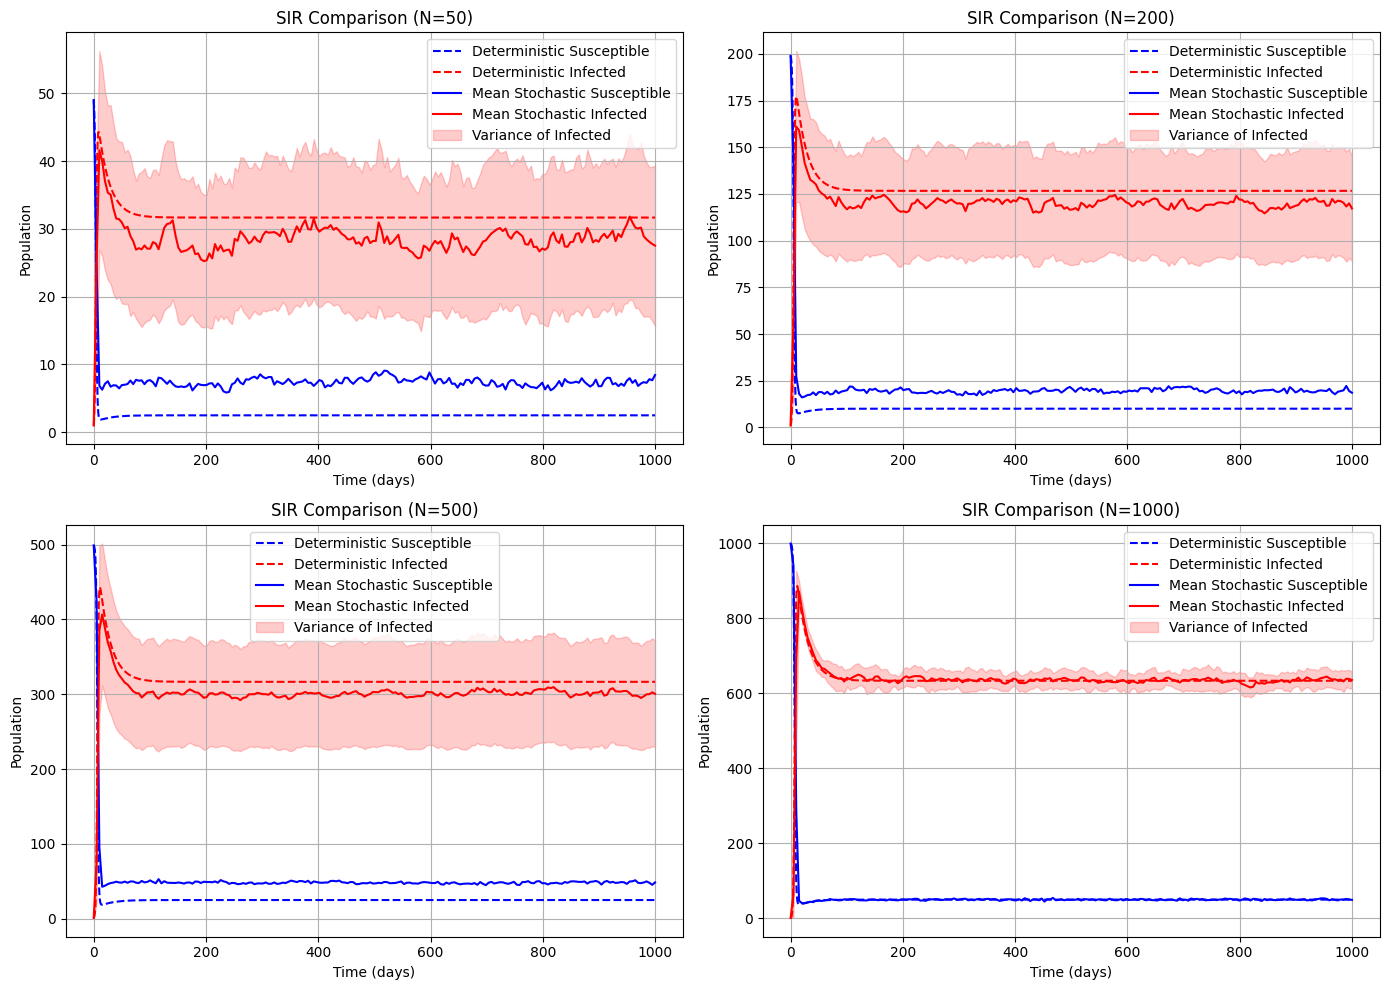

In [7]:
N = [50, 200, 500, 1000]
beta = 1
gamma = 1 / 60
mu = 1 / 30
start_t = 0
end_t = 1000
points_t = 1000
sims = 20
tend = 1000

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, n in enumerate(N):
    X0 = n - 1
    Y0 = 1
    Z0 = 0

    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, n, beta, gamma, mu, start_t, end_t, points_t)
    time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, n, tend)

    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected")
    
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    axs[i // 2, i % 2].set_title(f"SIR Comparison (N={n})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()


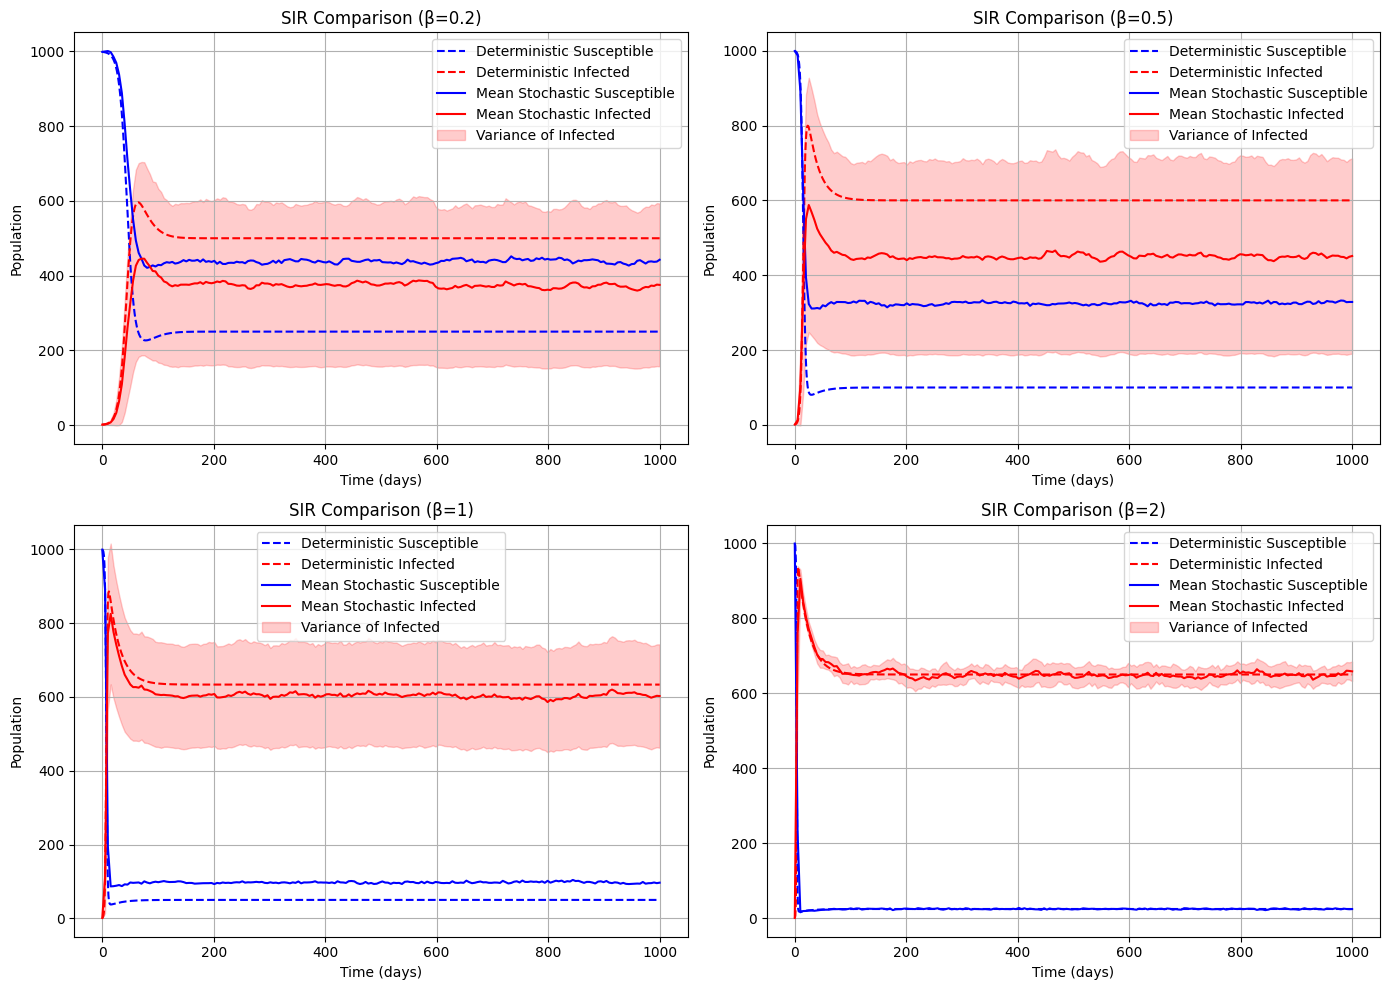

In [11]:
beta_values = [1 / 5, 1 / 2, 1, 2]  # Different values for beta
gamma = 1 / 60
mu = 1 / 30
start_t = 0
end_t = 1000
points_t = 1000
sims = 20
tend = 1000
N = 1000
X0 = 999
Y0 = 1
Z0 = 0

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, beta in enumerate(beta_values):

    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
    time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)

    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected")
    
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    axs[i // 2, i % 2].set_title(f"SIR Comparison (β={beta})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()

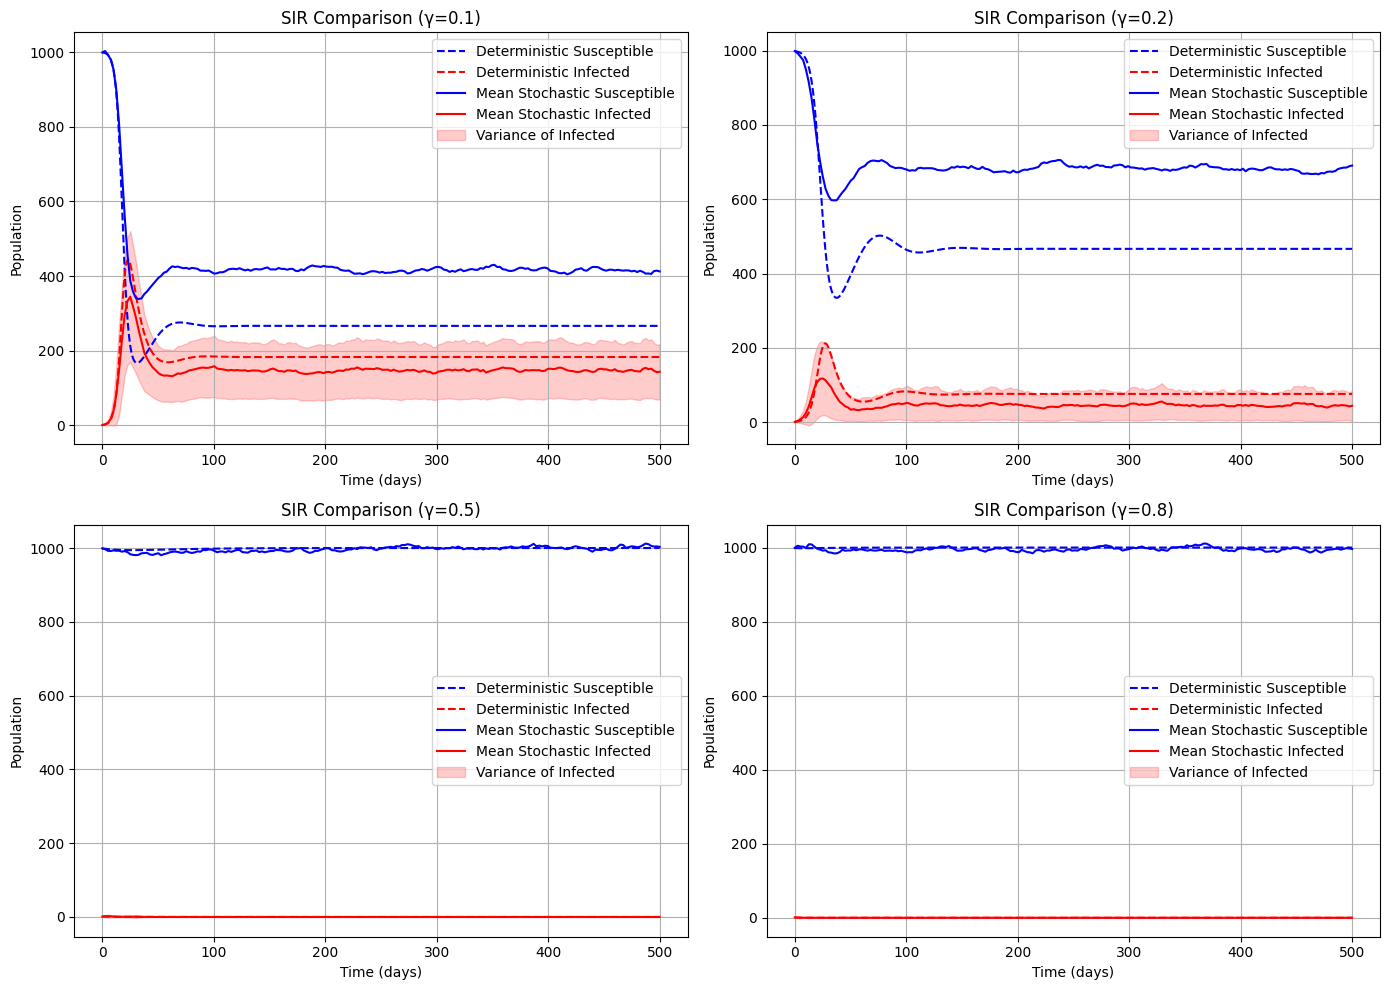

In [16]:
gamma_values = [1 / 10, 1 / 5, 1 / 2, 0.8 ]  # Different values for gamma
N = 1000 
beta = 0.5
mu = 1 / 30
start_t = 0
end_t = 500
points_t = 500
sims = 20
tend = 500
X0 = 999
Y0 = 1
Z0 = 0

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for i, gamma in enumerate(gamma_values):

    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
    time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)

    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected")
    
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    axs[i // 2, i % 2].set_title(f"SIR Comparison (γ={gamma})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()


# Extinction event (different R0, fixed population size N)

In [87]:
sims_ext = 10

X0 = 999
Y0 = 1
Z0 = 0

N = 1000 

# R0 = beta / (gamma + mu)

beta_ext = np.linspace(0, 15, sims_ext)
gamma_ext = np.linspace(0.01, 10, sims_ext)
mu_ext = np.linspace(0.01, 3, sims_ext)

R0_ext = beta_ext / (gamma_ext + mu_ext)

Yd_ext = []
Ys_ext = []
extinction_stoch = []  # To track whether extinction happened in stochastic runs
extinction_deter = []  # To track extinction in deterministic runs

for i in range(sims_ext):
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta_ext[i], gamma_ext[i], mu_ext[i], start_t = 0, end_t = 200, points_t = 200)
    Yd_ext.append(Yd[-1])
    extinction_deter.append(1 if Yd[-1] == 0 else 0)

    Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[i], gamma_ext[i], mu_ext[i], N, tend = 200, seed = i)
    Ys_ext.append(Ys[-1])
    extinction_stoch.append(1 if Ys[-1] == 0 else 0)

print("Stochastic extinctions:", np.sum(extinction_stoch), "out of " f"{sims_ext}" " simulations.")
print("Deterministic extinctions:", np.sum(extinction_deter),"out of " f"{sims_ext}" " simulations.")



Stochastic extinctions: 10 out of 10 simulations.
Deterministic extinctions: 0 out of 10 simulations.


For N = 500.0, total extinctions = 4, average extinction time = 62.25
For N = 1555.5555555555557, total extinctions = 10, average extinction time = 3646.6
For N = 2611.1111111111113, total extinctions = 9, average extinction time = 2733.6666666666665
For N = 3666.666666666667, total extinctions = 7, average extinction time = 3174.285714285714
For N = 4722.222222222223, total extinctions = 5, average extinction time = 2234.0
For N = 5777.777777777778, total extinctions = 1, average extinction time = 617.0
For N = 6833.333333333334, total extinctions = 1, average extinction time = 53.0
For N = 7888.88888888889, total extinctions = 1, average extinction time = 373.0
For N = 8944.444444444445, total extinctions = 0, average extinction time = nan
For N = 10000.0, total extinctions = 0, average extinction time = nan
For R0 = 5.0, total extinctions = 1, average extinction time = 72.0
For R0 = 1.0278084862444208, total extinctions = 10, average extinction time = 2683.2
For R0 = 1.0300739800713

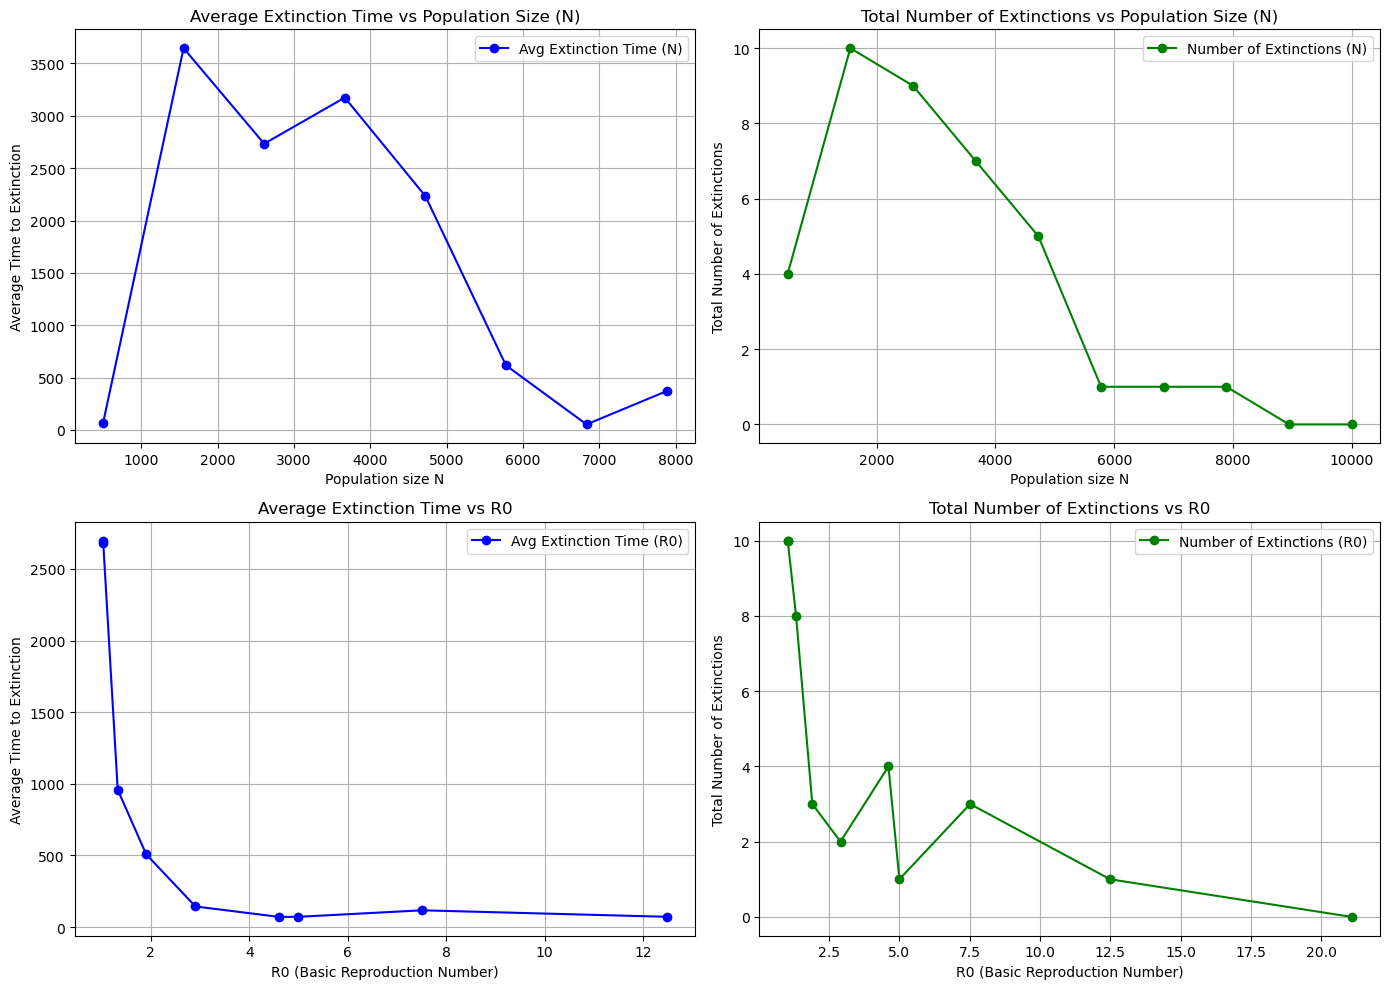

In [179]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulation_and_plot(param_diff, param_name, sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0):
    """
    General function to run simulations and plot extinction statistics.
    
    Args:
    - param_diff: Array of different values of N or R0.
    - param_name: Name of the parameter being varied ("N" or "R0").
    - sims_ext: Number of simulations to run for each parameter value.
    - beta_ext, gamma_ext, mu_ext: Arrays of transmission, recovery, and death rates.
    - t_end: End time for the simulation.
    - X0, Y0, Z0: Initial conditions (susceptible, infected, recovered).
    
    Returns:
    - Sorted parameter values and corresponding extinction data (for further plotting).
    """
    # Initialize lists to store results
    Ys_ext2 = []  # Average extinction times
    extinction_counts = []  # Number of extinctions for each parameter value

    # Loop over different values of the parameter (N or R0)
    for i, param in enumerate(param_diff):
        Ys_sim = []  # Temporary list to store extinction times for each simulation
        ext_count = 0  # Counter for the number of extinctions
        
        for sim in range(sims_ext):
            # Adjust X0 if simulating for different N values
            if param_name == "N":
                X0 = int(param) - 1  # Susceptible individuals (N-1)
            else:
                X0 = X0  # Keep it fixed for R0

            # Run the simulation using gillespie_sir for current beta, gamma, mu
            Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[i], gamma_ext[i], mu_ext[i], X0 + Y0 + Z0, tend=t_end, seed=sim)

            # Find the index of the first 0 in the Ys (extinction time)
            if 0 in Ys:
                extinction_time = Ys.index(0)
                Ys_sim.append(extinction_time)  # Only append if extinction happens
                ext_count += 1  # Increment extinction count if extinction occurs
            else:
                # If no extinction occurs, do nothing
                pass

        # Calculate the average extinction time only if there were extinctions
        if Ys_sim:
            average_extinction_time = sum(Ys_sim) / len(Ys_sim)
            Ys_ext2.append(average_extinction_time)
        else:
            Ys_ext2.append(np.nan)  # If no extinctions, append NaN

        extinction_counts.append(ext_count)  # Store the number of extinctions for this parameter
        print(f'For {param_name} = {param}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}')

    # Sort the parameter values and corresponding data
    sorted_indices = np.argsort(param_diff)
    param_diff_sorted = np.array(param_diff)[sorted_indices]
    Ys_ext2_sorted = np.array(Ys_ext2)[sorted_indices]
    extinction_counts_sorted = np.array(extinction_counts)[sorted_indices]

    return param_diff_sorted, Ys_ext2_sorted, extinction_counts_sorted


# Example parameters
sims_ext = 10  # Number of simulations per parameter
beta_ext = np.logspace(-1, 1.5, sims_ext)  # Transmission rates in the range [0.1, 31.6]
gamma_ext = np.linspace(0.01, 1, sims_ext)  # Recovery rates in the range [0.01, 1]
mu_ext = np.linspace(0.01, 0.5, sims_ext)  # Death rates in the range [0.01, 0.5]
t_end = 365  # Simulation end time

# N and R0 values
N_diff = np.linspace(500, 10000, 10)  # Population sizes for which we will run simulations
R0_diff = beta_ext / (gamma_ext + mu_ext)  # Calculate R0 values
X0 = 999  # Initial number of susceptible individuals
Y0 = 1  # Initial number of infected individuals
Z0 = 0  # Initial number of recovered individuals

# Run the simulations for N and R0
N_sorted, Ys_ext2_N_sorted, extinction_counts_N_sorted = run_simulation_and_plot(N_diff, "N", sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0)
R0_sorted, Ys_ext2_R0_sorted, extinction_counts_R0_sorted = run_simulation_and_plot(R0_diff, "R0", sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0)

# Create 2x2 subplot for all four plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Average extinction time vs N
ax[0, 0].plot(N_sorted, Ys_ext2_N_sorted, marker='o', color='blue', label='Avg Extinction Time (N)')
ax[0, 0].set_title("Average Extinction Time vs Population Size (N)")
ax[0, 0].set_xlabel("Population size N")
ax[0, 0].set_ylabel("Average Time to Extinction")
ax[0, 0].grid(True)
ax[0, 0].legend()

# Plot 2: Total number of extinctions vs N
ax[0, 1].plot(N_sorted, extinction_counts_N_sorted, marker='o', color='green', label='Number of Extinctions (N)')
ax[0, 1].set_title("Total Number of Extinctions vs Population Size (N)")
ax[0, 1].set_xlabel("Population size N")
ax[0, 1].set_ylabel("Total Number of Extinctions")
ax[0, 1].grid(True)
ax[0, 1].legend()

# Plot 3: Average extinction time vs R0
ax[1, 0].plot(R0_sorted, Ys_ext2_R0_sorted, marker='o', color='blue', label='Avg Extinction Time (R0)')
ax[1, 0].set_title("Average Extinction Time vs R0")
ax[1, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 0].set_ylabel("Average Time to Extinction")
ax[1, 0].grid(True)
ax[1, 0].legend()

# Plot 4: Total number of extinctions vs R0
ax[1, 1].plot(R0_sorted, extinction_counts_R0_sorted, marker='o', color='green', label='Number of Extinctions (R0)')
ax[1, 1].set_title("Total Number of Extinctions vs R0")
ax[1, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 1].set_ylabel("Total Number of Extinctions")
ax[1, 1].grid(True)
ax[1, 1].legend()

plt.tight_layout()
plt.show()


For N = 1000.0, total extinctions = 27, average extinction time = 4280.444444444444, extinction probability = 0.35
For N = 2000.0, total extinctions = 14, average extinction time = 7412.071428571428, extinction probability = 0.35
For N = 3000.0, total extinctions = 11, average extinction time = 1280.5454545454545, extinction probability = 0.35
For N = 4000.0, total extinctions = 10, average extinction time = 1696.9, extinction probability = 0.35
For N = 5000.0, total extinctions = 12, average extinction time = 1760.25, extinction probability = 0.35
For N = 6000.0, total extinctions = 14, average extinction time = 212.71428571428572, extinction probability = 0.35
For N = 7000.0, total extinctions = 15, average extinction time = 208.4, extinction probability = 0.35
For N = 8000.0, total extinctions = 13, average extinction time = 315.3076923076923, extinction probability = 0.35
For N = 9000.0, total extinctions = 11, average extinction time = 395.1818181818182, extinction probability = 0

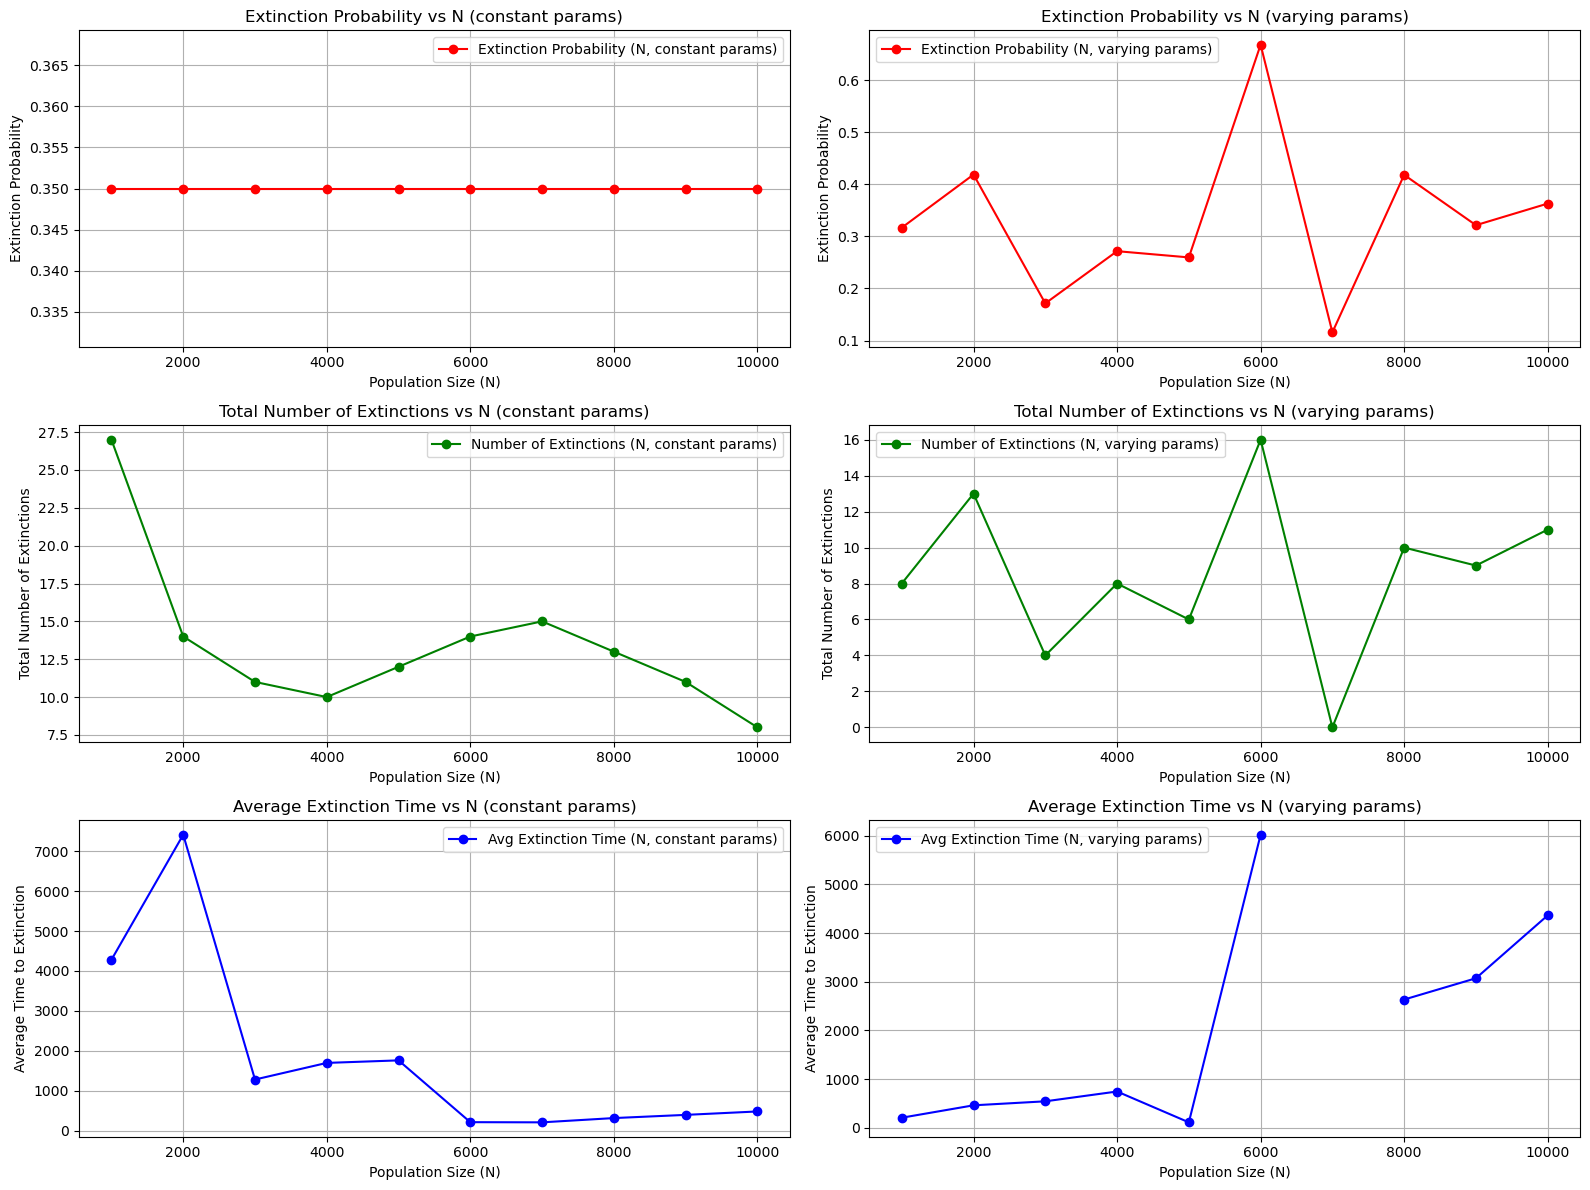

In [199]:
import numpy as np
import matplotlib.pyplot as plt

def calc_ext_prob(R0):
    """Calculate the extinction probability given R0, and ensure it's clipped to the [0, 1] range."""
    return np.clip(1 / R0, 0, 1)

def run_simulation_and_plotN(param_diff, param_name, sims_ext, beta_const, gamma_const, mu_const, t_end, X0, Y0, Z0, vary_params=False):
    """
    General function to run simulations and plot extinction statistics.
    
    Args:
    - param_diff: Array of different values of N or R0.
    - param_name: Name of the parameter being varied ("N" or "R0").
    - sims_ext: Number of simulations to run for each parameter value.
    - beta_const, gamma_const, mu_const: Constant transmission, recovery, and death rates.
    - t_end: End time for the simulation.
    - X0, Y0, Z0: Initial conditions (susceptible, infected, recovered).
    - vary_params: If True, vary beta, gamma, and mu for each N.
    
    Returns:
    - Sorted parameter values and corresponding extinction data (for further plotting).
    """
    # Initialize lists to store results
    Ys_ext2 = []  # Average extinction times
    extinction_counts = []  # Number of extinctions for each parameter value
    probabilities = []  # Extinction probabilities for each parameter value

    # Loop over different values of the parameter (N or R0)
    for i, param in enumerate(param_diff):
        Ys_sim = []  # Temporary list to store extinction times for each simulation
        ext_count = 0  # Counter for the number of extinctions

        # Vary parameters if necessary
        if vary_params:
            beta = np.random.uniform(0.1, 4)  # Vary beta randomly
            gamma = np.random.uniform(0.01, 1)   # Vary gamma randomly
            mu = np.random.uniform(0.01, 0.5)   # Vary mu randomly
            R0 = beta / (gamma + mu)  # Calculate new R0 for each N when varying parameters
        else:
            beta, gamma, mu = beta_const, gamma_const, mu_const  # Keep beta, gamma, mu constant
            R0 = beta / (gamma + mu)  # Fixed R0 based on constant parameters

        # Clip R0 if it's too small to avoid probabilities > 1
        if R0 < 1:
            R0 = 1.01  # Ensure R0 stays slightly above 1

        # Loop over simulations
        for sim in range(sims_ext):
            # Adjust X0 if simulating for different N values
            if param_name == "N":
                X0 = int(param) - 1  # Susceptible individuals (N-1)

            # Run the simulation using the gillespie_sir function (assuming it exists in your environment)
            Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, X0 + Y0 + Z0, tend=t_end, seed=sim)

            # Find the index of the first 0 in the Ys (extinction time)
            if 0 in Ys:
                extinction_time = Ys.index(0)
                Ys_sim.append(extinction_time)  # Only append if extinction happens
                ext_count += 1  # Increment extinction count if extinction occurs

        # Calculate the average extinction time only if there were extinctions
        if Ys_sim:
            average_extinction_time = sum(Ys_sim) / len(Ys_sim)
            Ys_ext2.append(average_extinction_time)
        else:
            Ys_ext2.append(np.nan)  # If no extinctions, append NaN

        # Append results for this parameter value
        extinction_counts.append(ext_count)  # Store the number of extinctions for this parameter
        probabilities.append(calc_ext_prob(R0))  # Store the calculated probability for this parameter

        print(f'For {param_name} = {param}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}, extinction probability = {probabilities[-1]}')

    # Sort the parameter values and corresponding data
    sorted_indices = np.argsort(param_diff)
    param_diff_sorted = np.array(param_diff)[sorted_indices]
    Ys_ext2_sorted = np.array(Ys_ext2)[sorted_indices]
    extinction_counts_sorted = np.array(extinction_counts)[sorted_indices]
    probabilities_sorted = np.array(probabilities)[sorted_indices]

    return param_diff_sorted, Ys_ext2_sorted, extinction_counts_sorted, probabilities_sorted


# Example parameters
sims_ext = 30  # Number of simulations per parameter
beta_const = 1  # Fixed transmission rate for N plots
gamma_const = 1/3  # Fixed recovery rate for N plots
mu_const = 1/60  # Fixed death rate for N plots
t_end = 365  # Simulation end time

# N values for varying N
N_diff = np.linspace(1000, 10000, 10)  # Population sizes for which we will run simulations
X0 = 999  # Initial number of susceptible individuals
Y0 = 1  # Initial number of infected individuals
Z0 = 0  # Initial number of recovered individuals

# ------------------ First set of plots: N with constant beta, gamma, and mu ------------------
N_sorted_const, Ys_ext2_N_const_sorted, extinction_counts_N_const_sorted, probabilities_N_const_sorted = run_simulation_and_plotN(N_diff, "N", sims_ext, beta_const, gamma_const, mu_const, t_end, X0, Y0, Z0)

# ------------------ Second set of plots: N with varying beta, gamma, and mu ------------------
N_sorted_vary, Ys_ext2_N_vary_sorted, extinction_counts_N_vary_sorted, probabilities_N_vary_sorted = run_simulation_and_plotN(N_diff, "N", sims_ext, beta_const, gamma_const, mu_const, t_end, X0, Y0, Z0, vary_params=True)

# Create 3x2 subplot for all six plots
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

# ------------------ First Row: Constant Parameters ------------------
# Plot 1: Extinction probability vs N (constant parameters)
ax[0, 0].plot(N_sorted_const, probabilities_N_const_sorted, marker='o', color='red', label='Extinction Probability (N, constant params)')
ax[0, 0].set_title("Extinction Probability vs N (constant params)")
ax[0, 0].set_xlabel("Population Size (N)")
ax[0, 0].set_ylabel("Extinction Probability")
ax[0, 0].grid(True)
ax[0, 0].legend()

# Plot 2: Total number of extinctions vs N (constant parameters)
ax[1, 0].plot(N_sorted_const, extinction_counts_N_const_sorted, marker='o', color='green', label='Number of Extinctions (N, constant params)')
ax[1, 0].set_title("Total Number of Extinctions vs N (constant params)")
ax[1, 0].set_xlabel("Population Size (N)")
ax[1, 0].set_ylabel("Total Number of Extinctions")
ax[1, 0].grid(True)
ax[1, 0].legend()

# Plot 3: Average extinction time vs N (constant parameters)
ax[2, 0].plot(N_sorted_const, Ys_ext2_N_const_sorted, marker='o', color='blue', label='Avg Extinction Time (N, constant params)')
ax[2, 0].set_title("Average Extinction Time vs N (constant params)")
ax[2, 0].set_xlabel("Population Size (N)")
ax[2, 0].set_ylabel("Average Time to Extinction")
ax[2, 0].grid(True)
ax[2, 0].legend()

# ------------------ Second Row: Varying Parameters ------------------
# Plot 4: Extinction probability vs N (varying parameters)
ax[0, 1].plot(N_sorted_vary, probabilities_N_vary_sorted, marker='o', color='red', label='Extinction Probability (N, varying params)')
ax[0, 1].set_title("Extinction Probability vs N (varying params)")
ax[0, 1].set_xlabel("Population Size (N)")
ax[0, 1].set_ylabel("Extinction Probability")
ax[0, 1].grid(True)
ax[0, 1].legend()

# Plot 5: Total number of extinctions vs N (varying parameters)
ax[1, 1].plot(N_sorted_vary, extinction_counts_N_vary_sorted, marker='o', color='green', label='Number of Extinctions (N, varying params)')
ax[1, 1].set_title("Total Number of Extinctions vs N (varying params)")
ax[1, 1].set_xlabel("Population Size (N)")
ax[1, 1].set_ylabel("Total Number of Extinctions")
ax[1, 1].grid(True)
ax[1, 1].legend()

# Plot 6: Average extinction time vs N (varying parameters)
ax[2, 1].plot(N_sorted_vary, Ys_ext2_N_vary_sorted, marker='o', color='blue', label='Avg Extinction Time (N, varying params)')
ax[2, 1].set_title("Average Extinction Time vs N (varying params)")
ax[2, 1].set_xlabel("Population Size (N)")
ax[2, 1].set_ylabel("Average Time to Extinction")
ax[2, 1].grid(True)
ax[2, 1].legend()

plt.tight_layout()
plt.show()


For R0 = 1.1, total extinctions = 6, average extinction time = 2965.5, extinction probability = 0.9090909090909091
For R0 = 1.5333333333333334, total extinctions = 6, average extinction time = 791.8333333333334, extinction probability = 0.6521739130434783
For R0 = 1.9666666666666668, total extinctions = 7, average extinction time = 635.8571428571429, extinction probability = 0.5084745762711864
For R0 = 2.4000000000000004, total extinctions = 6, average extinction time = 407.0, extinction probability = 0.41666666666666663
For R0 = 2.8333333333333335, total extinctions = 7, average extinction time = 777.4285714285714, extinction probability = 0.3529411764705882
For R0 = 3.266666666666667, total extinctions = 2, average extinction time = 737.0, extinction probability = 0.3061224489795918
For R0 = 3.7, total extinctions = 1, average extinction time = 72.0, extinction probability = 0.27027027027027023
For R0 = 4.133333333333333, total extinctions = 1, average extinction time = 72.0, extinct

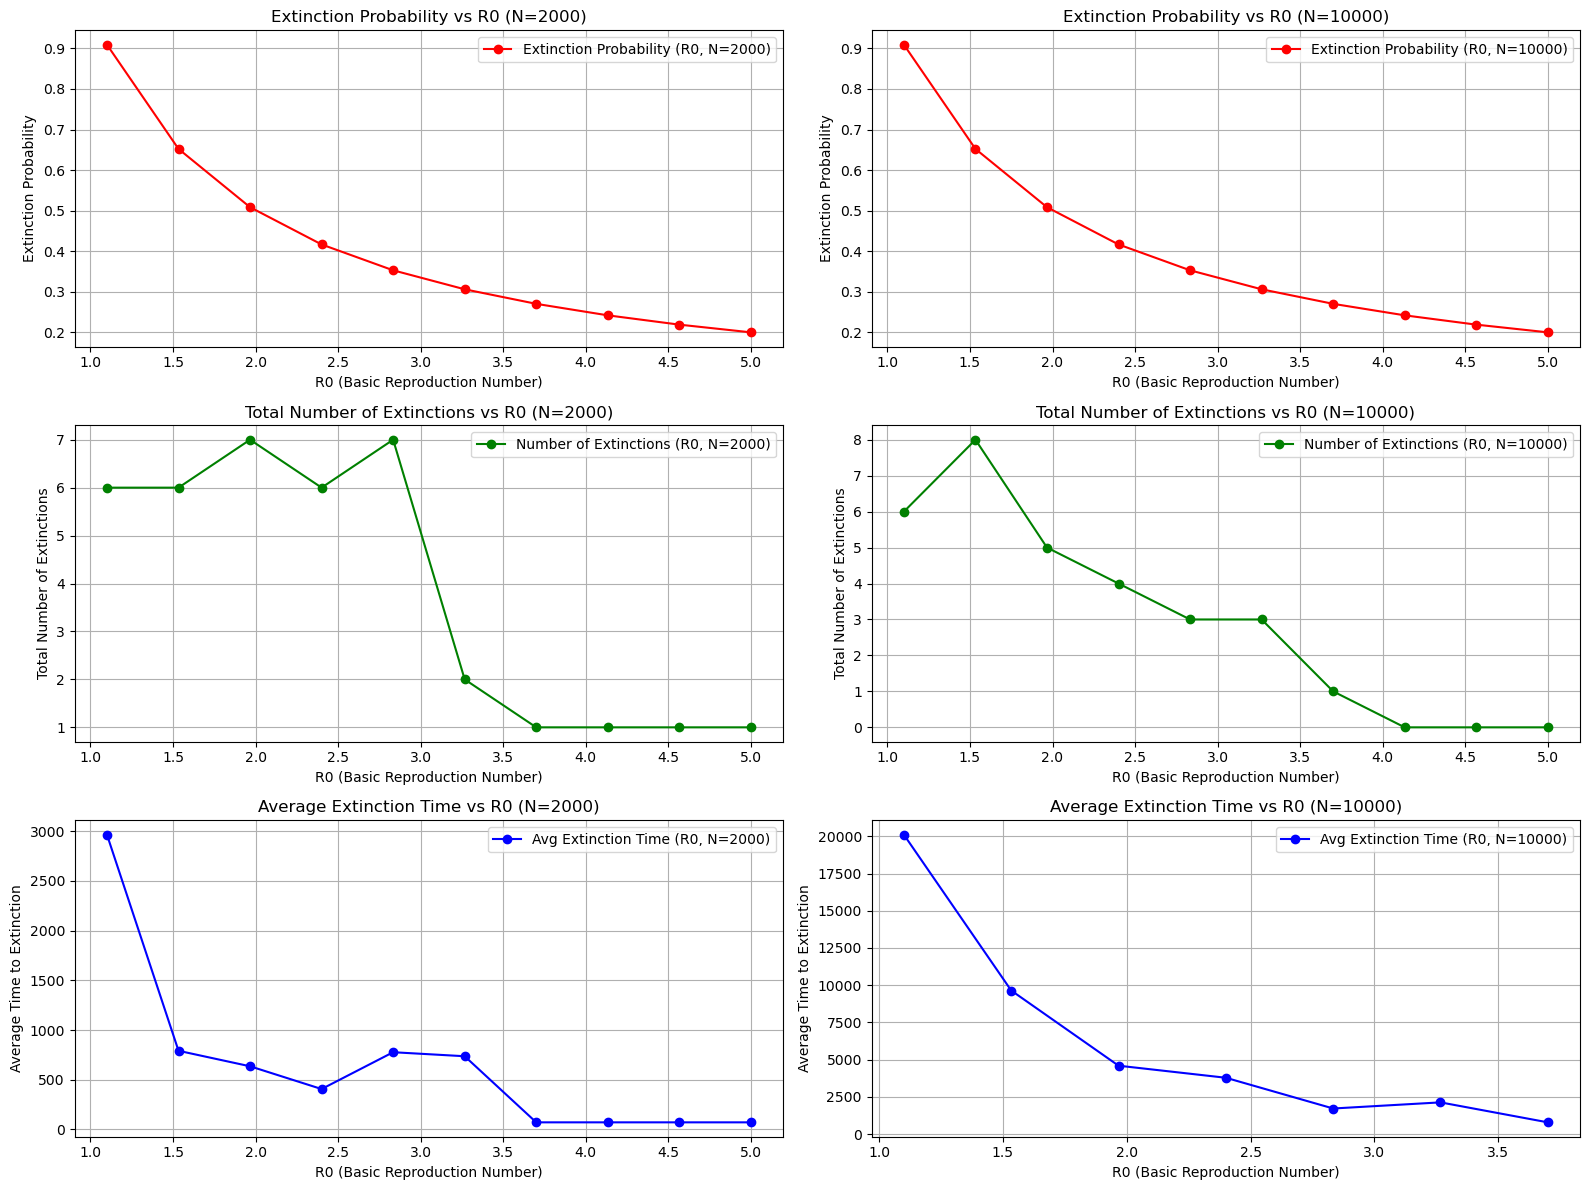

In [186]:
import numpy as np
import matplotlib.pyplot as plt

def calc_ext_prob(R0):
    """Calculate the extinction probability given R0 (with i=1 initial infection)."""
    return 1 / R0

def run_simulation_and_plot_r0(param_diff, param_name, sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0):
    """
    General function to run simulations and plot extinction statistics for varying R0.
    
    Args:
    - param_diff: Array of different values of R0.
    - param_name: Name of the parameter being varied ("R0").
    - sims_ext: Number of simulations to run for each parameter value.
    - beta_ext, gamma_ext, mu_ext: Arrays of transmission, recovery, and death rates.
    - t_end: End time for the simulation.
    - X0, Y0, Z0: Initial conditions (susceptible, infected, recovered).
    
    Returns:
    - Sorted parameter values and corresponding extinction data (for further plotting).
    """
    # Initialize lists to store results
    Ys_ext2 = []  # Average extinction times
    extinction_counts = []  # Number of extinctions for each parameter value
    probabilities = []  # Extinction probabilities for each parameter value

    # Loop over different values of R0
    for i, R0 in enumerate(param_diff):
        Ys_sim = []  # Temporary list to store extinction times for each simulation
        ext_count = 0  # Counter for the number of extinctions

        beta = R0 * (gamma_ext[i % len(gamma_ext)] + mu_ext[i % len(mu_ext)])  # Calculate beta for given R0
        gamma = gamma_ext[i % len(gamma_ext)]  # Recovery rate
        mu = mu_ext[i % len(mu_ext)]  # Death rate

        # Loop over simulations
        for sim in range(sims_ext):
            # Run the simulation using the gillespie_sir function (assuming it exists in your environment)
            Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, X0 + Y0 + Z0, tend=t_end, seed=sim)

            # Find the index of the first 0 in the Ys (extinction time)
            if 0 in Ys:
                extinction_time = Ys.index(0)
                Ys_sim.append(extinction_time)  # Only append if extinction happens
                ext_count += 1  # Increment extinction count if extinction occurs

        # Calculate the average extinction time only if there were extinctions
        if Ys_sim:
            average_extinction_time = sum(Ys_sim) / len(Ys_sim)
            Ys_ext2.append(average_extinction_time)
        else:
            Ys_ext2.append(np.nan)  # If no extinctions, append NaN

        # Append results for this parameter value
        extinction_counts.append(ext_count)  # Store the number of extinctions for this parameter
        probabilities.append(calc_ext_prob(R0))  # Store the calculated probability for this parameter

        print(f'For {param_name} = {R0}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}, extinction probability = {probabilities[-1]}')

    # Sort the parameter values and corresponding data
    sorted_indices = np.argsort(param_diff)
    param_diff_sorted = np.array(param_diff)[sorted_indices]
    Ys_ext2_sorted = np.array(Ys_ext2)[sorted_indices]
    extinction_counts_sorted = np.array(extinction_counts)[sorted_indices]
    probabilities_sorted = np.array(probabilities)[sorted_indices]

    return param_diff_sorted, Ys_ext2_sorted, extinction_counts_sorted, probabilities_sorted


# Example parameters
sims_ext = 10  # Number of simulations per parameter
gamma_ext = np.linspace(0.01, 1, sims_ext)  # Recovery rates in the range [0.01, 1]
mu_ext = np.linspace(0.01, 0.5, sims_ext)  # Death rates in the range [0.01, 0.5]
t_end = 365  # Simulation end time

# R0 values for varying R0
R0_diff = np.linspace(1.1, 5, 10)  # Vary R0 values directly

# ------------------ First set of plots: R0 with N = 2000 ------------------
X0_2000 = 2000 - 1  # Susceptible individuals for N = 2000
Y0 = 1  # Initial number of infected individuals
Z0 = 0  # Initial number of recovered individuals

R0_sorted_2000, Ys_ext2_R0_sorted_2000, extinction_counts_R0_sorted_2000, probabilities_R0_sorted_2000 = run_simulation_and_plot_r0(
    R0_diff, "R0", sims_ext, None, gamma_ext, mu_ext, t_end, X0_2000, Y0, Z0)

# ------------------ Second set of plots: R0 with N = 10000 ------------------
X0_10000 = 10000 - 1  # Susceptible individuals for N = 10000

R0_sorted_10000, Ys_ext2_R0_sorted_10000, extinction_counts_R0_sorted_10000, probabilities_R0_sorted_10000 = run_simulation_and_plot_r0(
    R0_diff, "R0", sims_ext, None, gamma_ext, mu_ext, t_end, X0_10000, Y0, Z0)

# Create 3x2 subplot for all six plots
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

# ------------------ First Row: N = 2000 ------------------
# Plot 1: Extinction probability vs R0 (N = 2000)
ax[0, 0].plot(R0_sorted_2000, probabilities_R0_sorted_2000, marker='o', color='red', label='Extinction Probability (R0, N=2000)')
ax[0, 0].set_title("Extinction Probability vs R0 (N=2000)")
ax[0, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[0, 0].set_ylabel("Extinction Probability")
ax[0, 0].grid(True)
ax[0, 0].legend()

# Plot 2: Total number of extinctions vs R0 (N = 2000)
ax[1, 0].plot(R0_sorted_2000, extinction_counts_R0_sorted_2000, marker='o', color='green', label='Number of Extinctions (R0, N=2000)')
ax[1, 0].set_title("Total Number of Extinctions vs R0 (N=2000)")
ax[1, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 0].set_ylabel("Total Number of Extinctions")
ax[1, 0].grid(True)
ax[1, 0].legend()

# Plot 3: Average extinction time vs R0 (N = 2000)
ax[2, 0].plot(R0_sorted_2000, Ys_ext2_R0_sorted_2000, marker='o', color='blue', label='Avg Extinction Time (R0, N=2000)')
ax[2, 0].set_title("Average Extinction Time vs R0 (N=2000)")
ax[2, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[2, 0].set_ylabel("Average Time to Extinction")
ax[2, 0].grid(True)
ax[2, 0].legend()

# ------------------ Second Row: N = 10000 ------------------
# Plot 4: Extinction probability vs R0 (N = 10000)
ax[0, 1].plot(R0_sorted_10000, probabilities_R0_sorted_10000, marker='o', color='red', label='Extinction Probability (R0, N=10000)')
ax[0, 1].set_title("Extinction Probability vs R0 (N=10000)")
ax[0, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[0, 1].set_ylabel("Extinction Probability")
ax[0, 1].grid(True)
ax[0, 1].legend()

# Plot 5: Total number of extinctions vs R0 (N = 10000)
ax[1, 1].plot(R0_sorted_10000, extinction_counts_R0_sorted_10000, marker='o', color='green', label='Number of Extinctions (R0, N=10000)')
ax[1, 1].set_title("Total Number of Extinctions vs R0 (N=10000)")
ax[1, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 1].set_ylabel("Total Number of Extinctions")
ax[1, 1].grid(True)
ax[1, 1].legend()

# Plot 6: Average extinction time vs R0 (N = 10000)
ax[2, 1].plot(R0_sorted_10000, Ys_ext2_R0_sorted_10000, marker='o', color='blue', label='Avg Extinction Time (R0, N=10000)')
ax[2, 1].set_title("Average Extinction Time vs R0 (N=10000)")
ax[2, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[2, 1].set_ylabel("Average Time to Extinction")
ax[2, 1].grid(True)
ax[2, 1].legend()

plt.tight_layout()
plt.show()


# Problem 2


#### 2.1 Implement SIR and Simulate

In [2]:
output_notebook()

# Function to generate networks
def generate_networks(nodes, edge_prob_erdos, edge_prob_watts, k_connections_watts, nr_edges_barb):
    erdos = nx.erdos_renyi_graph(nodes, edge_prob_erdos)
    watts = nx.watts_strogatz_graph(nodes, k_connections_watts, edge_prob_watts)
    barabasi = nx.barabasi_albert_graph(nodes, nr_edges_barb)
    return [erdos, watts, barabasi]

# Function to run SIR model on a given network
def run_sir_model(network, beta, gamma, fraction_infected, num_iterations = 50):
    model = ep.SIRModel(network)
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_parameter('fraction_infected', fraction_infected)
    model.set_initial_status(cfg)

    simulations = model.iteration_bunch(num_iterations)
    
    iterations = [sim['iteration'] for sim in simulations]
    susceptible = [sim['node_count'][0] for sim in simulations]
    infected = [sim['node_count'][1] for sim in simulations]
    recovered = [sim['node_count'][2] for sim in simulations]
    
    return iterations, susceptible, infected, recovered

def plot_results(networks, results, titles):
    plots = []
    prevalence_plots = []
    for idx, (iterations, susceptible, infected_counts, recovered) in enumerate(results):

        p = figure(title=titles[idx], x_axis_label='Iterations', y_axis_label='Number of Individuals', width=400, height=400)
        
        p.line(iterations, susceptible, legend_label='Susceptible', color='blue', line_width=2)
        p.line(iterations, infected_counts, legend_label='Infected', color='red', line_width=2)
        p.line(iterations, recovered, legend_label='Recovered', color='green', line_width=2)
        
        p.legend.title = "States"
        p.legend.location = "top_right"
        
        plots.append(p)

        # Compute prevalence of Infectious individuals
        total_population = susceptible[0] + infected_counts[0] + recovered[0]
        prevalence = [i / total_population for i in infected_counts]

        prevalence_plot = figure(title=f"{titles[idx]} - Prevalence", x_axis_label='Iterations', y_axis_label='Proportion Infected',
                                 width=400, height=400)

        prevalence_plot.line(iterations, prevalence, legend_label='Prevalence', color='purple', line_width=2)
        prevalence_plot.legend.location = "top_right"
        
        prevalence_plots.append(prevalence_plot)

    grid = gridplot([[plots[0], plots[1], plots[2]], [prevalence_plots[0], prevalence_plots[1], prevalence_plots[2]]])
    show(grid)

# Function to run multiple simulations across networks
def run_networks(beta, gamma, fraction_infected, nodes, edge_prob_erdos, edge_prob_watts, k_connections_watts, nr_edges_barb, repetitions, num_iterations = 50, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    networks = generate_networks(nodes, edge_prob_erdos, edge_prob_watts, k_connections_watts, nr_edges_barb)
    titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
    results = []
    
    # Repeat the simulation across each network for the given number of repetitions
    for network in networks:
        all_susceptible = np.zeros(num_iterations)
        all_infected = np.zeros(num_iterations)
        all_recovered = np.zeros(num_iterations)

        for _ in range(repetitions):
            iterations, susceptible, infected, recovered = run_sir_model(network, beta, gamma, fraction_infected)
            all_susceptible += np.array(susceptible)
            all_infected += np.array(infected)
            all_recovered += np.array(recovered)

        avg_susceptible = all_susceptible / repetitions
        avg_infected = all_infected / repetitions
        avg_recovered = all_recovered / repetitions
        
        results.append((iterations, avg_susceptible, avg_infected, avg_recovered))

    plot_results(networks, results, titles)

Loading BokehJS ...

In [3]:
run_networks(beta=1, gamma = 1/3, fraction_infected=0.02, nodes=1000, edge_prob_erdos=0.1, edge_prob_watts=0.1, k_connections_watts=4, nr_edges_barb=2, repetitions=40, seed=42)

100%|██████████| 50/50 [00:00<00:00, 1730.48it/s]


#### 2.2 Generate Networks of equivalent form

In [4]:
# Function to generate and plot network models, degree distributions, and centralities
def generate_and_plot_networks_with_centralities(nodes, k, p_watts, m_barabasi, p_erdos, seed=None):
    # Set seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)  # Seed numpy as well for further consistency
    
    # Generate the networks
    watts = nx.watts_strogatz_graph(nodes, k, p_watts, seed=seed)
    barabasi = nx.barabasi_albert_graph(nodes, m_barabasi, seed=seed)
    erdos = nx.erdos_renyi_graph(nodes, p_erdos, seed=seed)

    # Plot the networks
    plt.figure(figsize=(18, 6))
    
    # Watts-Strogatz
    plt.subplot(1, 3, 1)
    nx.draw(watts, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
    plt.title(f'Watts-Strogatz ($k={k}, p={p_watts}$)')

    # Barabási-Albert
    plt.subplot(1, 3, 2)
    nx.draw(barabasi, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
    plt.title(f'Barabási-Albert ($m={m_barabasi}$)')

    # Erdős-Rényi
    plt.subplot(1, 3, 3)
    nx.draw(erdos, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
    plt.title(f'Erdős-Rényi ($p={p_erdos}$)')
    
    plt.tight_layout()
    plt.show()

    # Plot the degree distributions
    plt.figure(figsize=(18, 6))
    
    # Watts-Strogatz Degree Distribution
    plt.subplot(1, 3, 1)
    watts_degrees = [d for n, d in watts.degree()]
    sns.histplot(watts_degrees, bins=10)
    plt.title(f'Watts-Strogatz Degree Distribution\n$k={k}, p={p_watts}$')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')

    # Barabási-Albert Degree Distribution
    plt.subplot(1, 3, 2)
    barabasi_degrees = [d for n, d in barabasi.degree()]
    sns.histplot(barabasi_degrees, bins=10)
    plt.title(f'Barabási-Albert Degree Distribution\n$m={m_barabasi}$')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')

    # Erdős-Rényi Degree Distribution
    plt.subplot(1, 3, 3)
    erdos_degrees = [d for n, d in erdos.degree()]
    sns.histplot(erdos_degrees, bins=10)
    plt.title(f'Erdős-Rényi Degree Distribution\n$p={p_erdos}$')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    
    plt.tight_layout()
    plt.show()

    # Centrality measures and plots for each network
    for net, name in zip([watts, barabasi, erdos], ['Watts-Strogatz', 'Barabási-Albert', 'Erdős-Rényi']):
        plt.figure(figsize=(18, 6))
        
        # Degree Centrality
        degree_centrality = nx.degree_centrality(net)
        degree_values = list(degree_centrality.values())
        plt.subplot(1, 3, 1)
        sns.histplot(degree_values, bins=10)
        plt.axvline(x=np.mean(degree_values), color='red', linestyle='--', label='Mean Degree Centrality')
        plt.title(f'{name} Degree Centrality')
        plt.xlabel('Centrality Value')
        plt.ylabel('Number of Nodes')
        plt.legend()

        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(net)
        betweenness_values = list(betweenness_centrality.values())
        plt.subplot(1, 3, 2)
        sns.histplot(betweenness_values, bins=10)
        plt.axvline(x=np.mean(betweenness_values), color='red', linestyle='--', label='Mean Betweenness Centrality')
        plt.title(f'{name} Betweenness Centrality')
        plt.xlabel('Centrality Value')
        plt.ylabel('Number of Nodes')
        plt.legend()

        # Closeness Centrality
        closeness_centrality = nx.closeness_centrality(net)
        closeness_values = list(closeness_centrality.values())
        plt.subplot(1, 3, 3)
        sns.histplot(closeness_values, bins=10)
        plt.axvline(x=np.mean(closeness_values), color='red', linestyle='--', label='Mean Closeness Centrality')
        plt.title(f'{name} Closeness Centrality')
        plt.xlabel('Centrality Value')
        plt.ylabel('Number of Nodes')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    return watts, barabasi, erdos  # Return the networks for future use


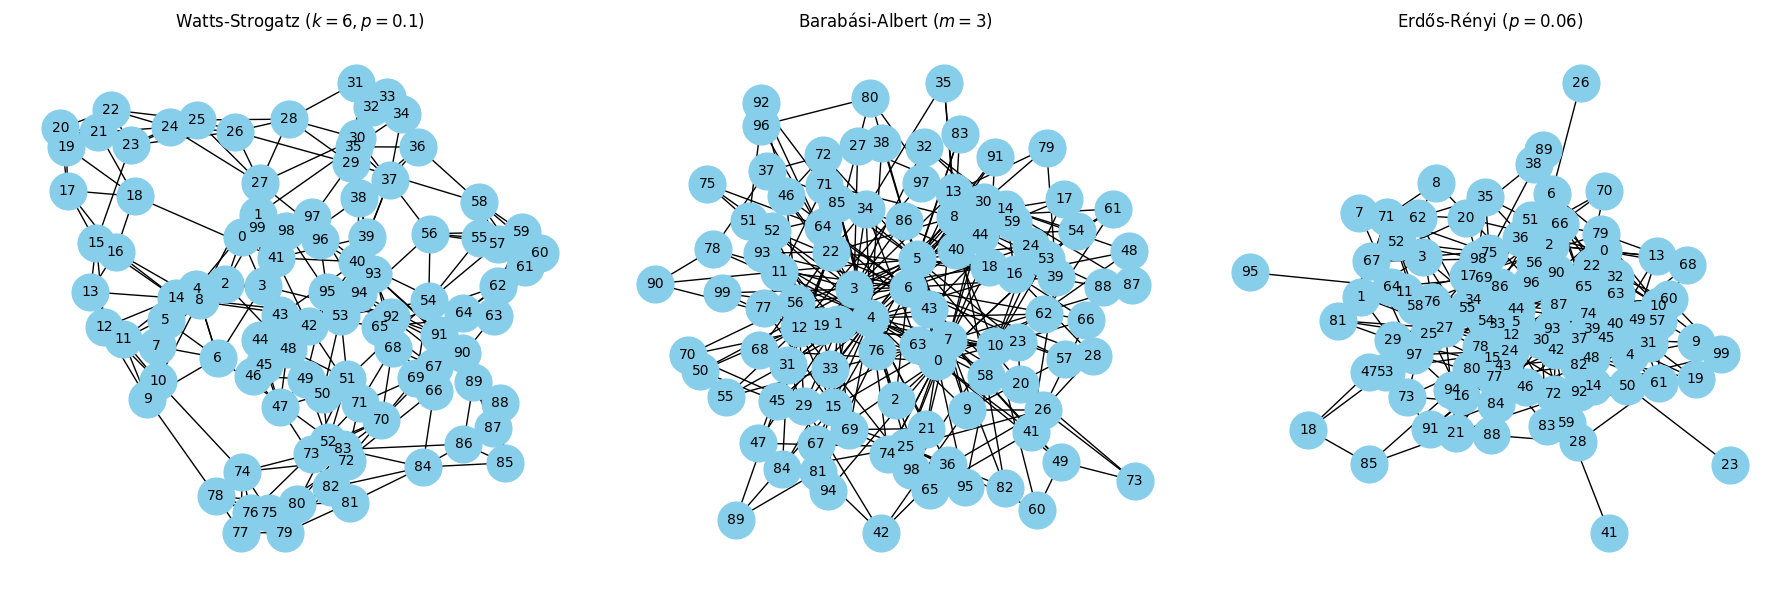

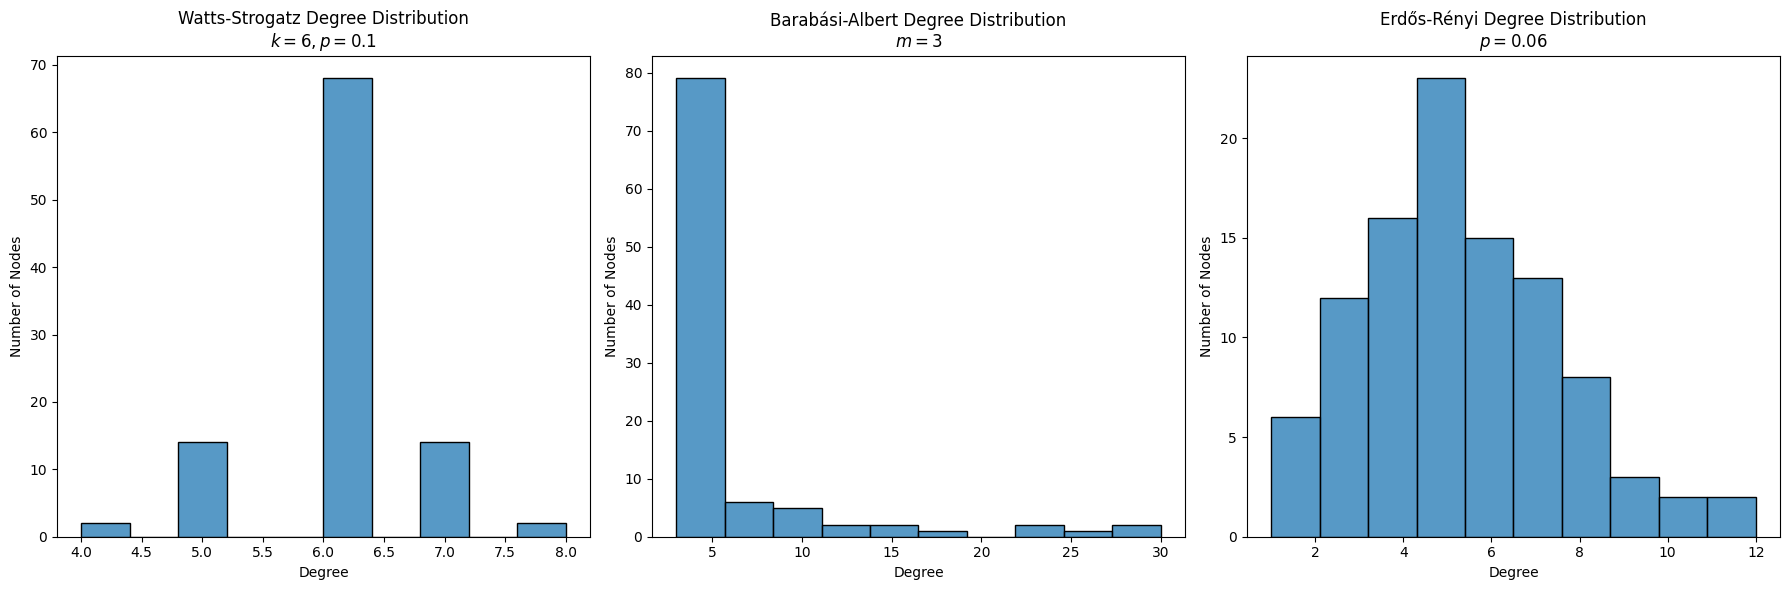

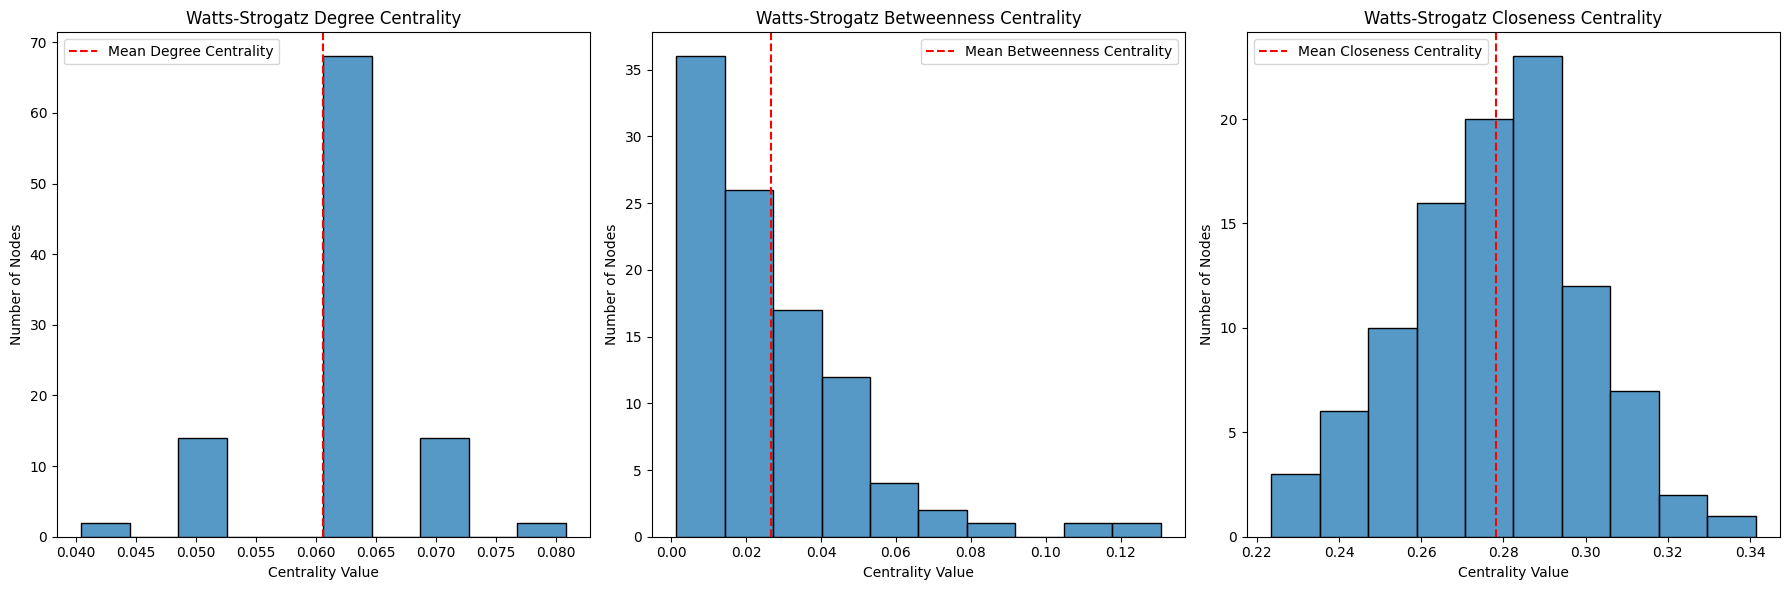

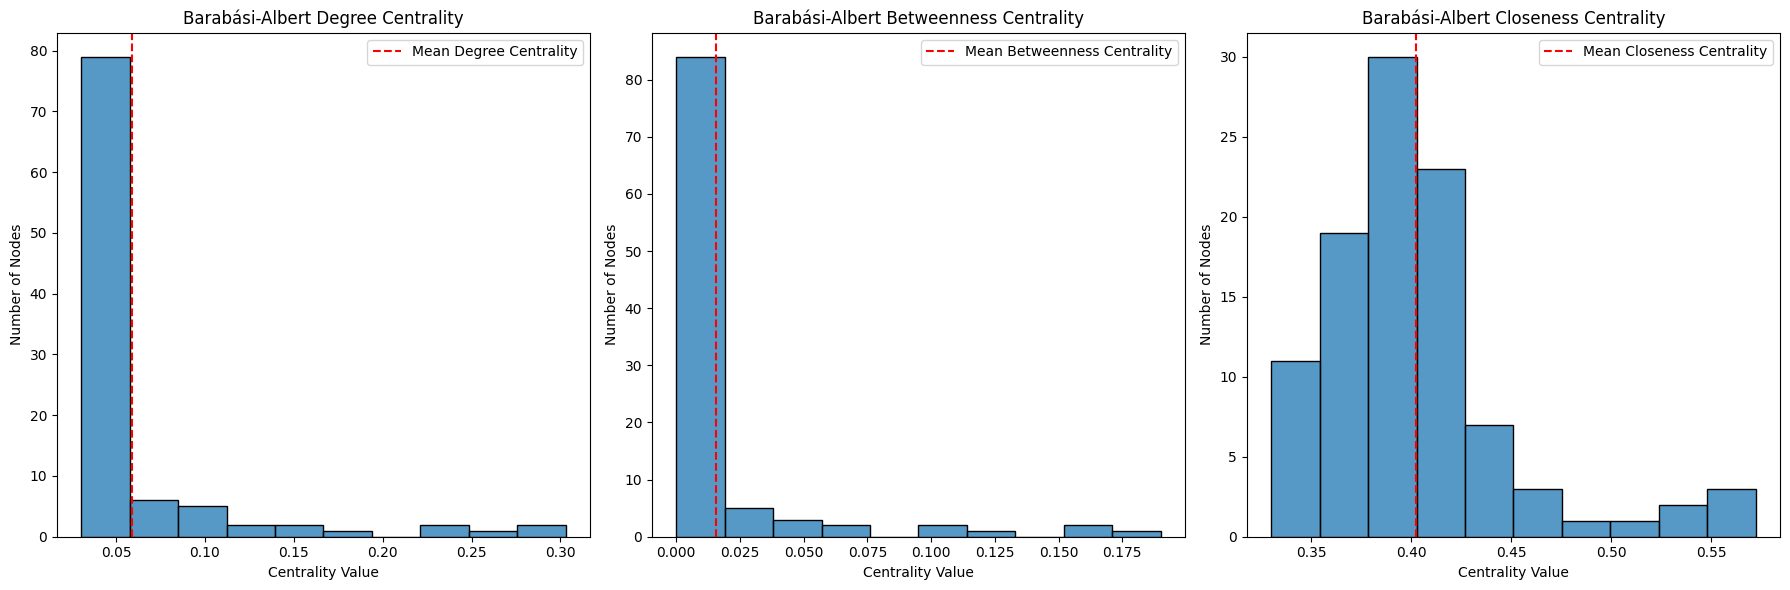

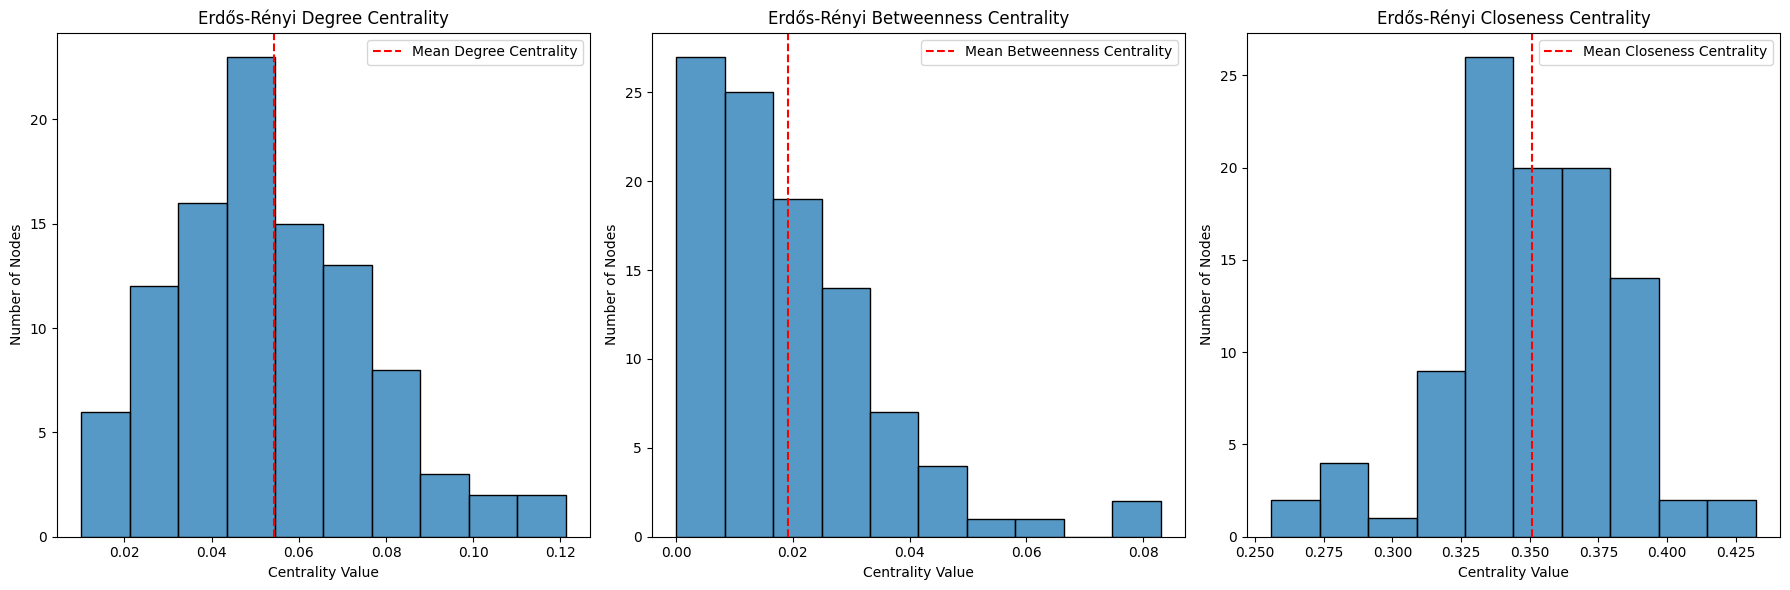

In [5]:
watts1, barabasi1, erdos1 = generate_and_plot_networks_with_centralities(nodes=100, k=6, p_watts=0.1, m_barabasi=3, p_erdos=0.06, seed=42)

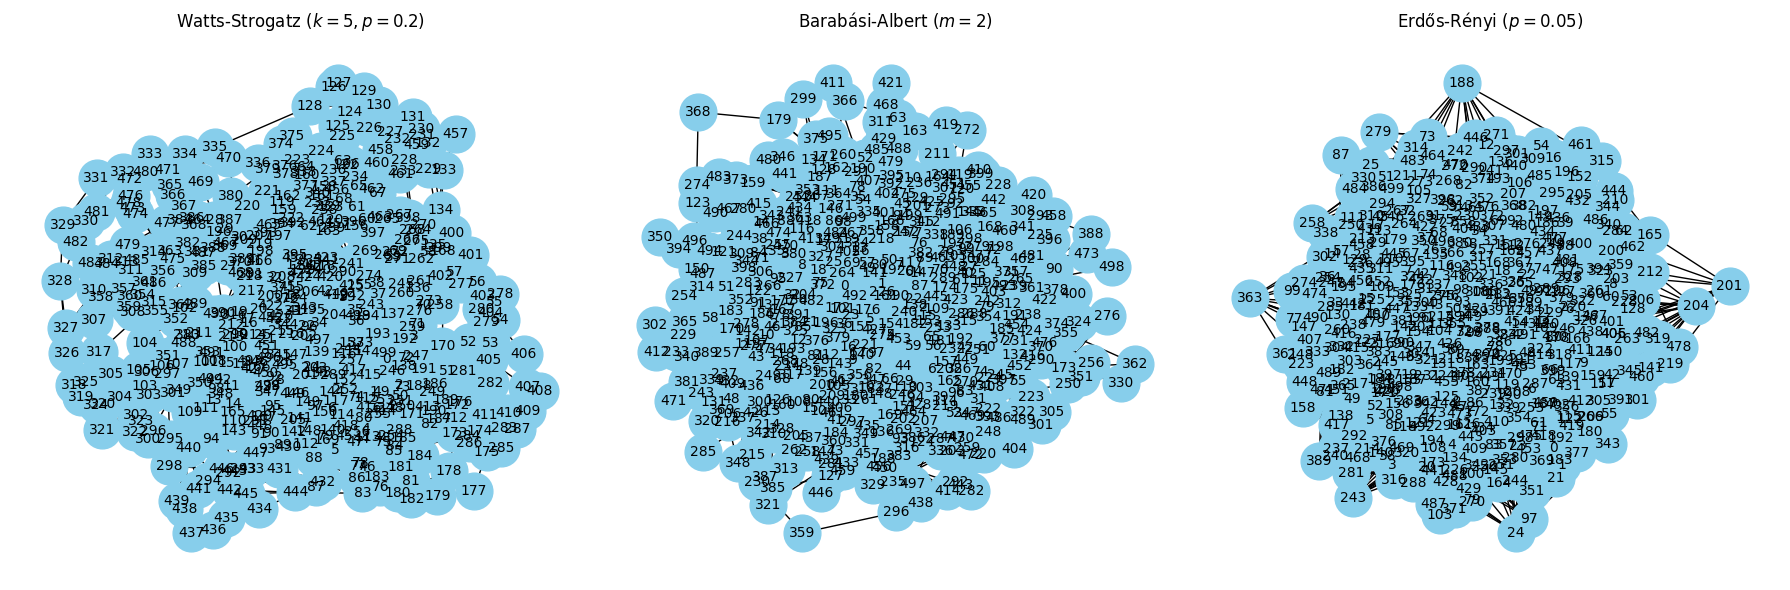

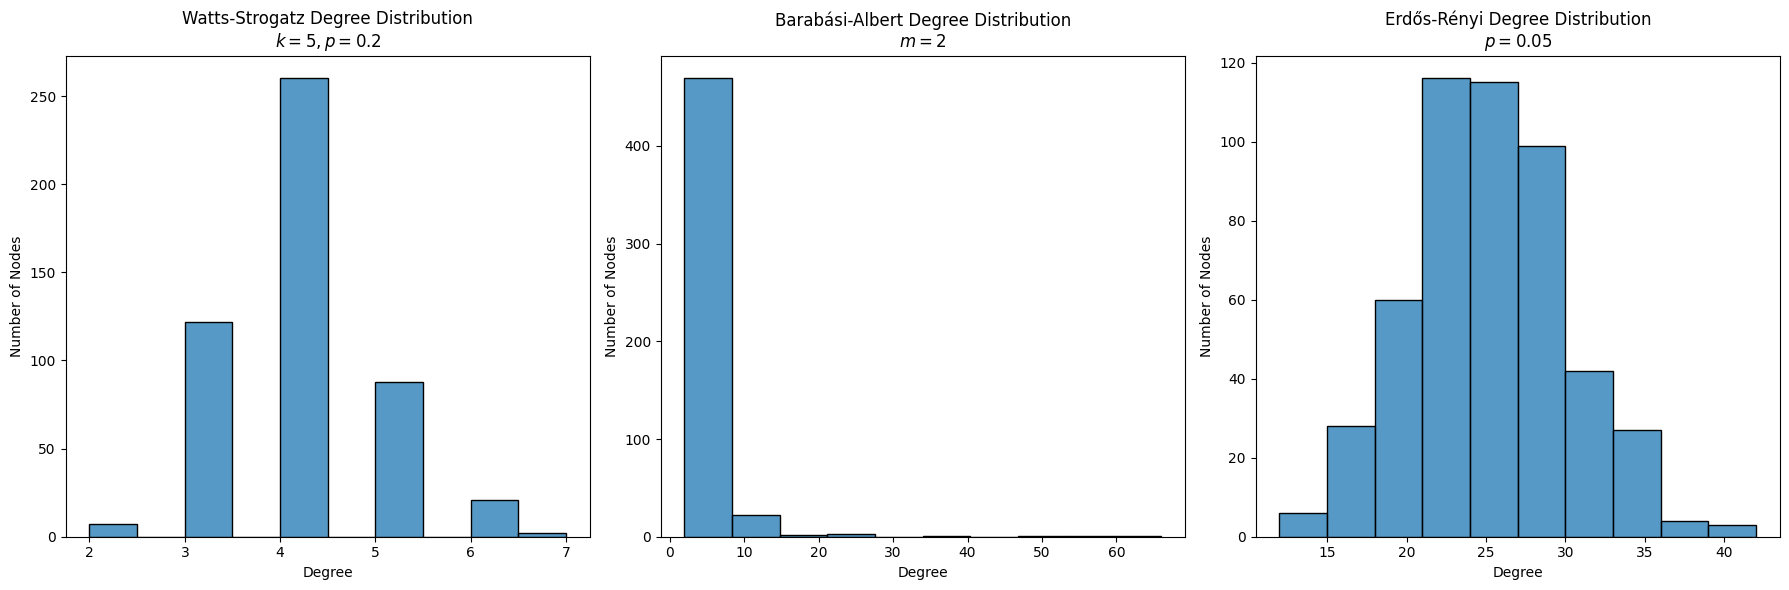

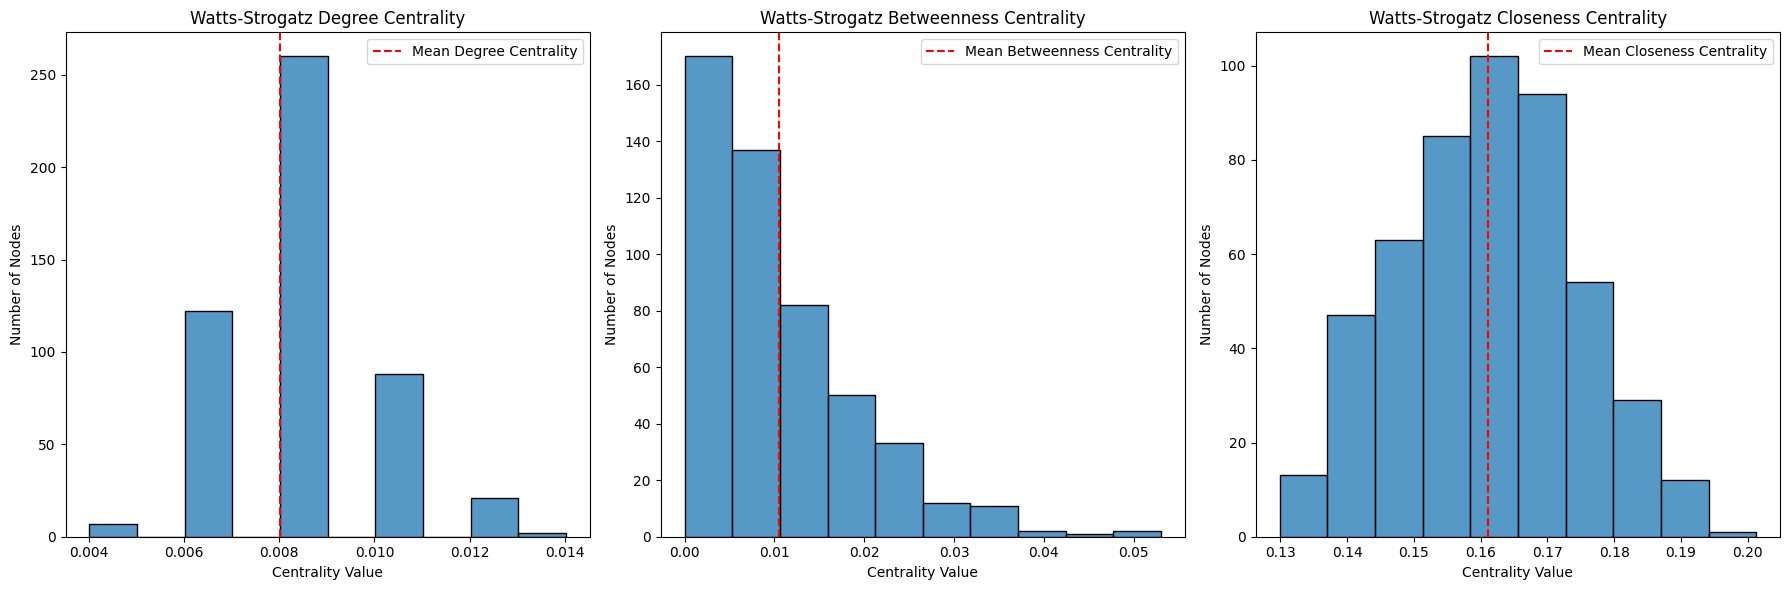

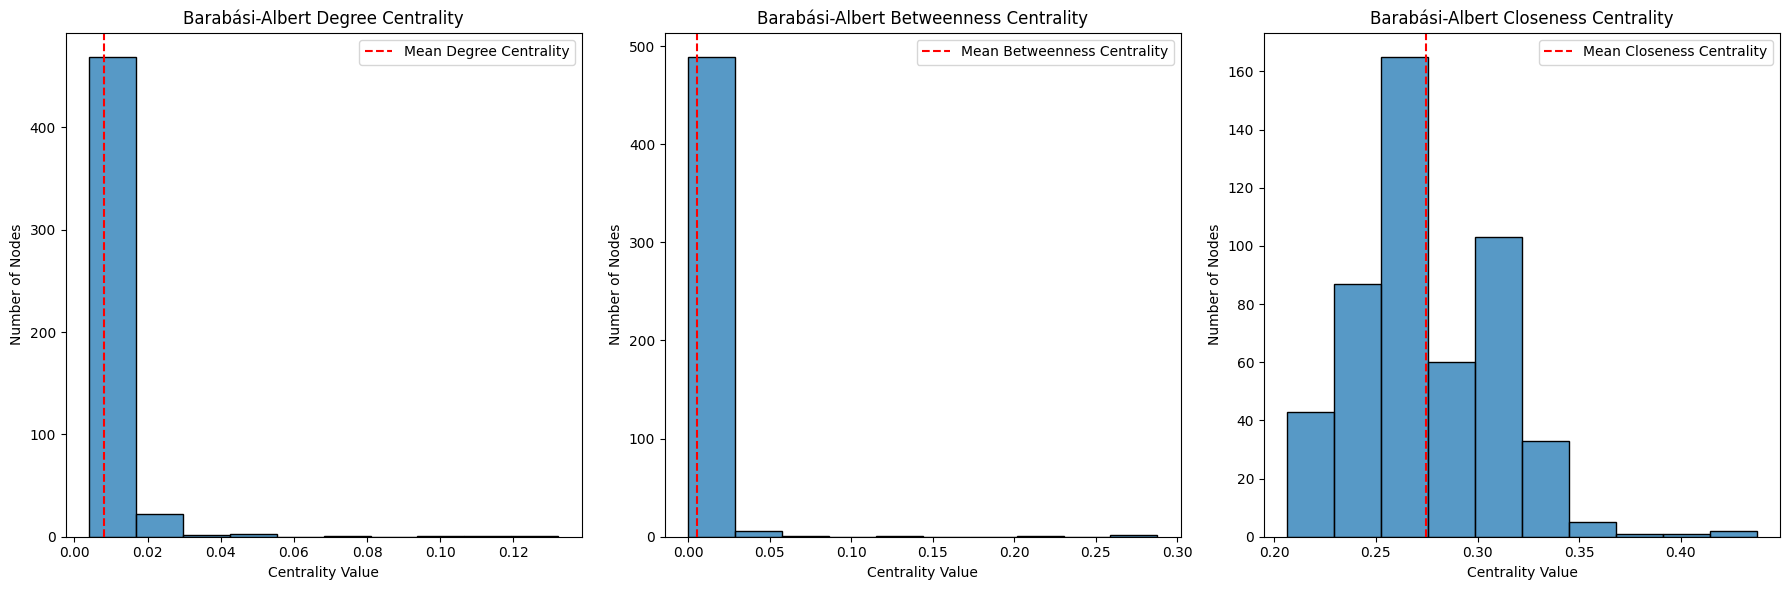

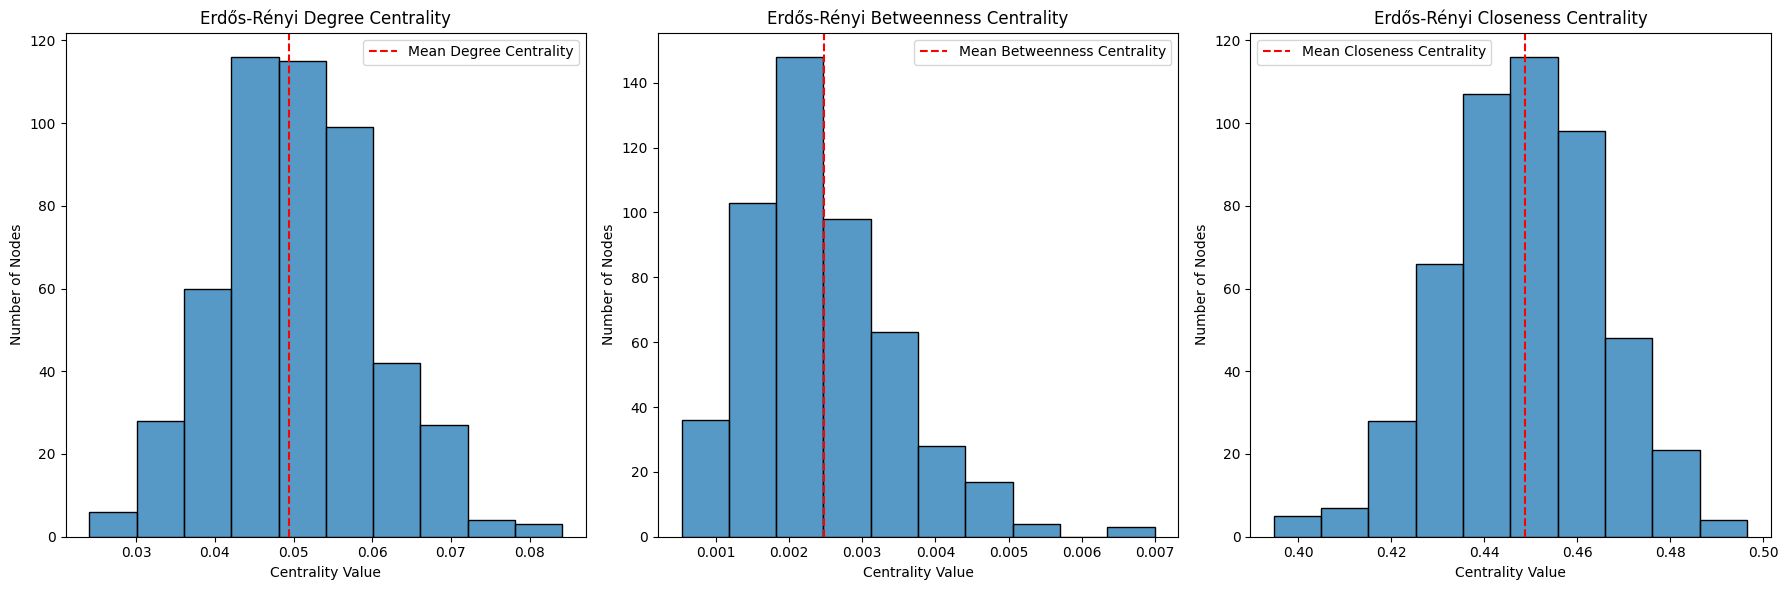

In [6]:
watts2, barabasi2, erdos2 = generate_and_plot_networks_with_centralities(nodes=500, k=5, p_watts=0.2, m_barabasi=2, p_erdos=0.05, seed=42)

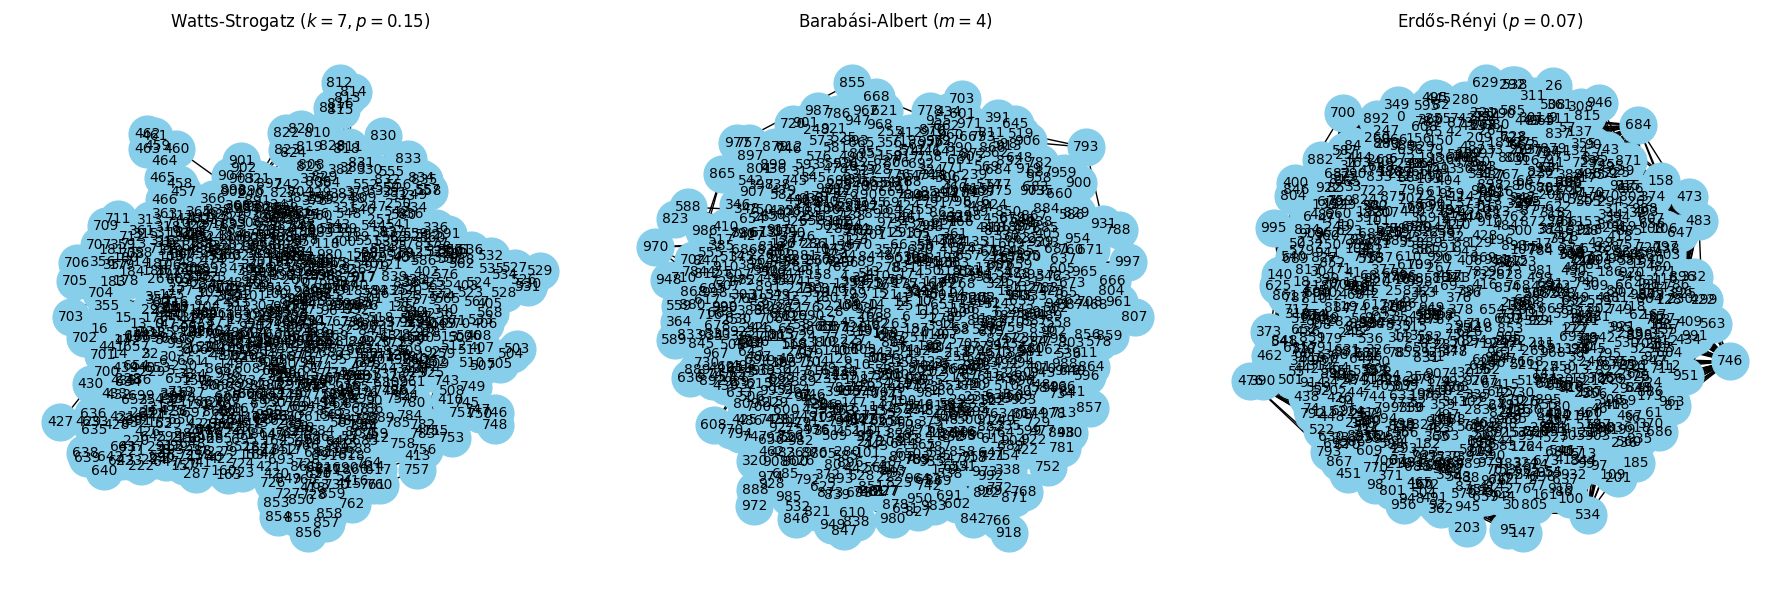

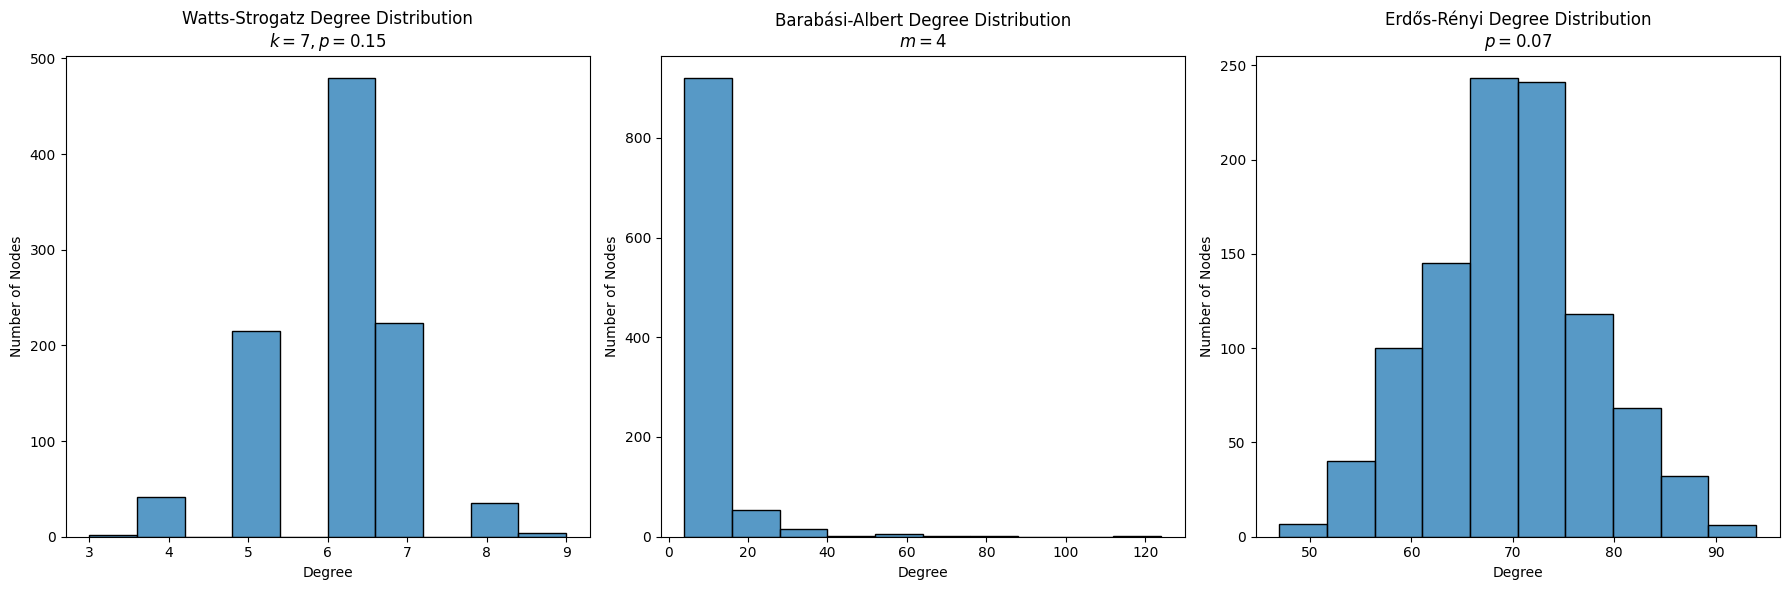

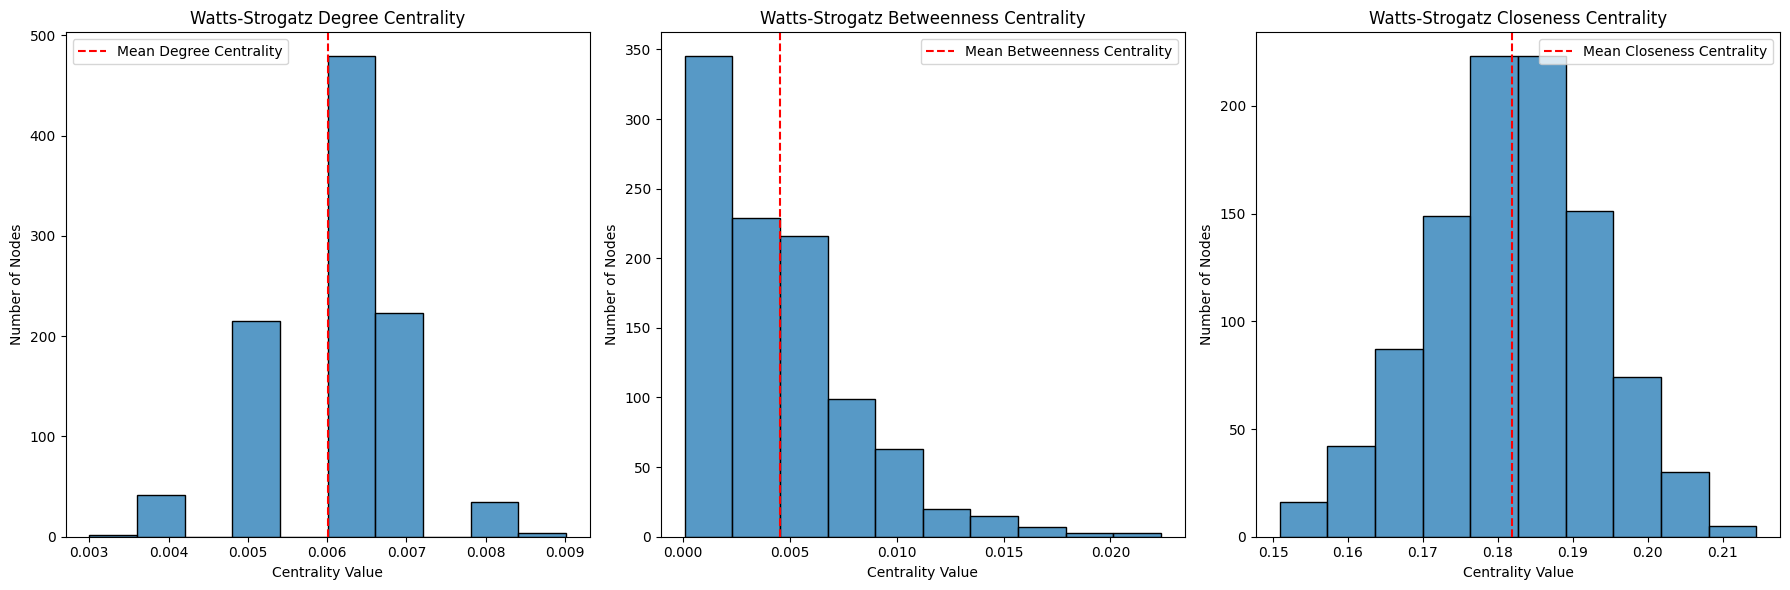

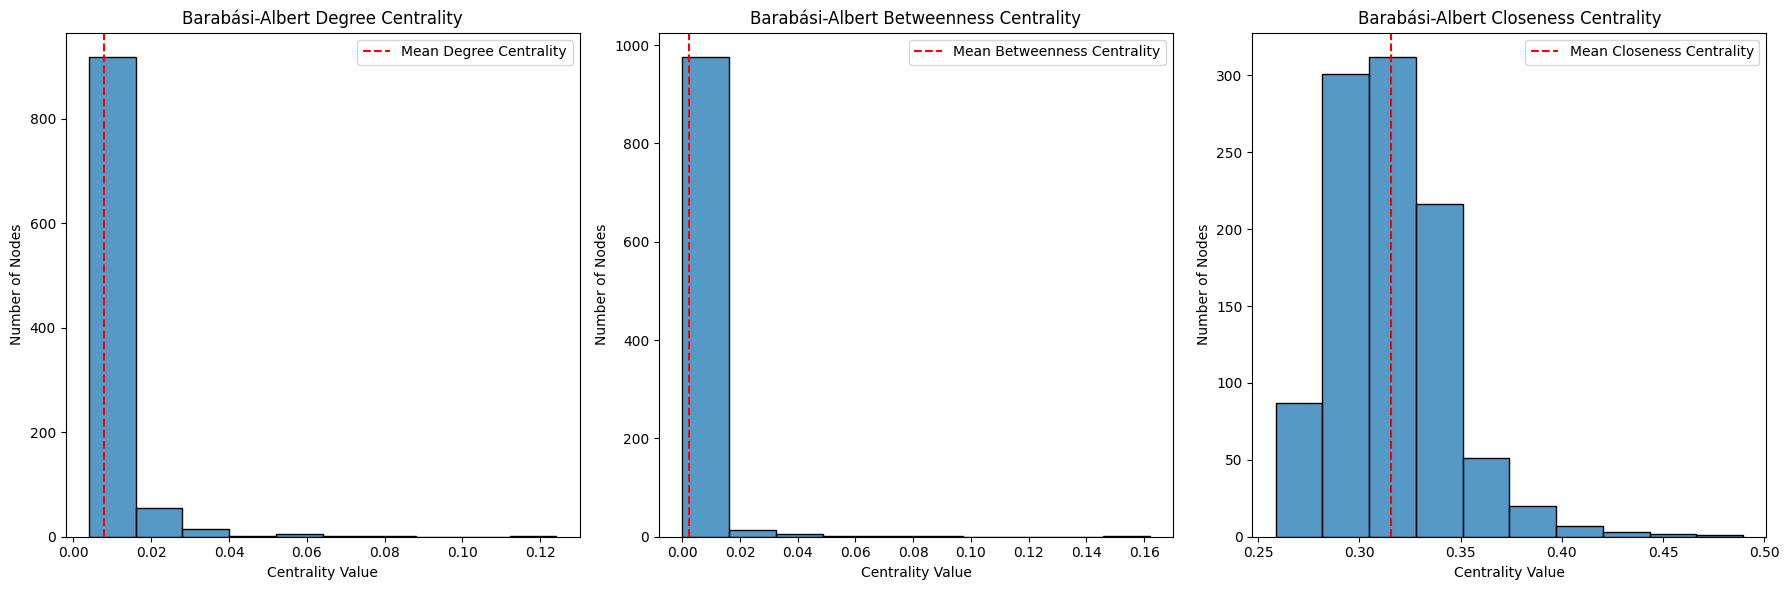

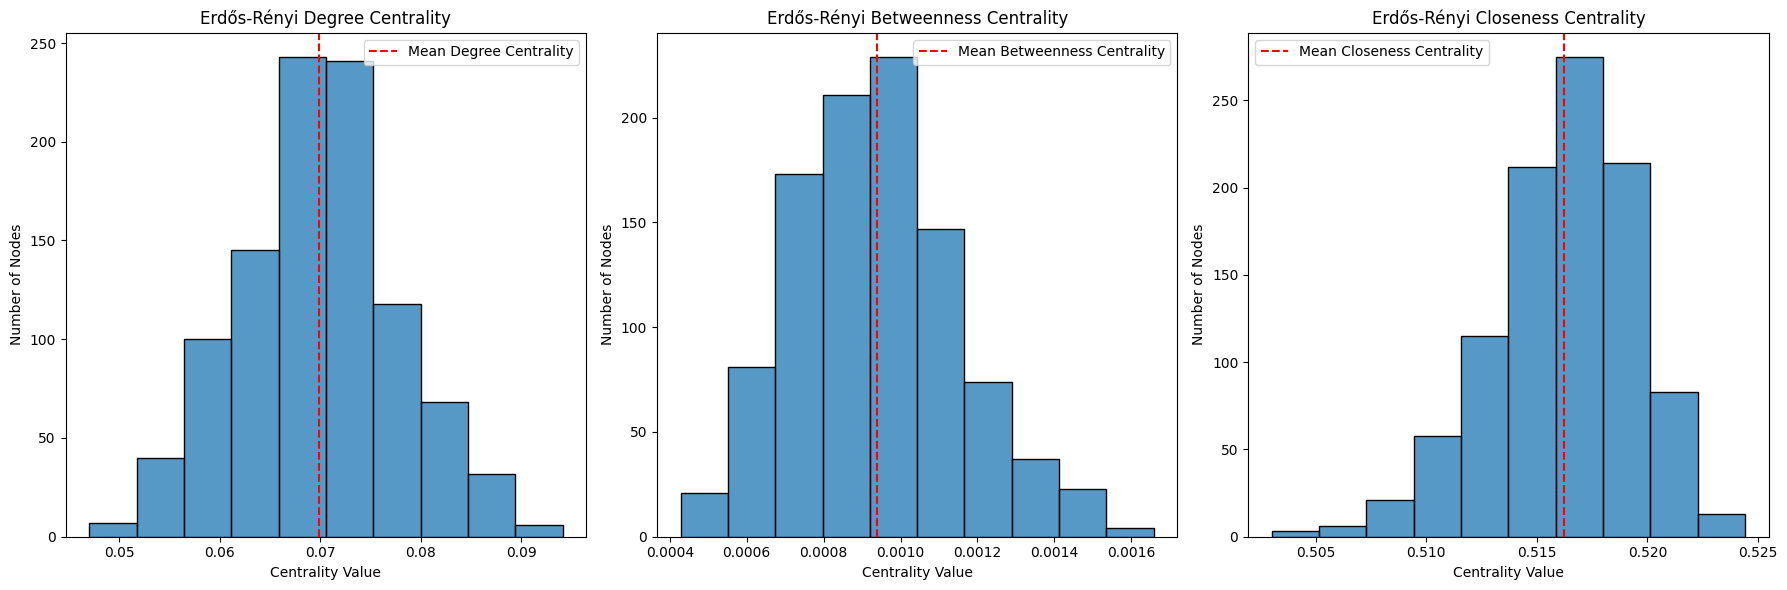

In [10]:
watts3, barabasi3, erdos3 = generate_and_plot_networks_with_centralities(nodes=1000, k=7, p_watts=0.15, m_barabasi=4, p_erdos=0.07, seed=42)

#### 2.3 Simulate SIR spread on the network

In [7]:
# Function to run multiple simulations across networks and varying parameters
def run_networks(networks, titles, beta, gamma, fraction_infected, repetitions, num_iterations=50, seed=None):
    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    results = []
    infected_nodes_lists = []  # Initialize list to store initial infected nodes for each network
    
    # Repeat the simulation across each network for the given number of repetitions
    for index, network in enumerate(networks):
        # Create the model
        model = ep.SIRModel(network)

        # Create the configuration and add parameters
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        cfg.add_model_parameter('fraction_infected', fraction_infected)
        model.set_initial_status(cfg)

        # Get initial infected nodes
        initial_infected_nodes = [node for node in network.nodes() if model.status[node] == 1]
        infected_nodes_lists.append(initial_infected_nodes)  # Store in the infected_nodes_lists

        all_susceptible = np.zeros(num_iterations)
        all_infected = np.zeros(num_iterations)
        all_recovered = np.zeros(num_iterations)

        for _ in range(repetitions):
            iterations, susceptible, infected, recovered = run_sir_model(network, beta, gamma, fraction_infected)
            all_susceptible += np.array(susceptible)
            all_infected += np.array(infected)
            all_recovered += np.array(recovered)

        # Averaging over repetitions
        avg_susceptible = all_susceptible / repetitions
        avg_infected = all_infected / repetitions
        avg_recovered = all_recovered / repetitions
        
        results.append((iterations, avg_susceptible, avg_infected, avg_recovered))

    plot_results(networks, results, titles)
    
    return infected_nodes_lists  # Return the list of initial infected nodes for each network

# Example usage
# Assuming networks is a list of your three network structures
# networks = [watts2, barabasi2, erdos2]
# titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
# infected_nodes_lists = run_networks(networks, titles, beta=1, gamma=0.05, fraction_infected=0.02, repetitions=20)

# Print the initial infected nodes for verification
# print(infected_nodes_lists)


# Example usage
# Assuming networks is a list of your three network structures
networks = [watts2, barabasi2, erdos2]
titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
infected_nodes_lists = run_networks(networks, titles, beta=1, gamma=0.05, fraction_infected=0.02, repetitions=20)




100%|██████████| 50/50 [00:00<00:00, 1627.54it/s]


In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Function to plot the initial conditions of multiple networks side by side
def plot_initial_conditions_3d(networks, infected_nodes_lists, titles):
    fig = plt.figure(figsize=(16, 5))

    for i, (network, infected_nodes) in enumerate(zip(networks, infected_nodes_lists)):
        # Get a 3D layout for the network
        pos = nx.spring_layout(network, dim=3, seed=42)  # Seed for consistent layout

        # Create a 3D subplot
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        ax.set_title(titles[i])
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')

        # Prepare node positions for 3D plotting
        node_xyz = np.array([pos[v] for v in sorted(network)])
        x_vals, y_vals, z_vals = node_xyz[:, 0], node_xyz[:, 1], node_xyz[:, 2]

        # Define node colors based on their state at t=0
        node_colors = ['red' if node in infected_nodes else 'blue' for node in network.nodes()]

        # Plot nodes
        ax.scatter(x_vals, y_vals, z_vals, c=node_colors, s=100, edgecolor='k', alpha=0.8)

        # Plot edges
        for i, j in network.edges():
            x = np.array((pos[i][0], pos[j][0]))
            y = np.array((pos[i][1], pos[j][1]))
            z = np.array((pos[i][2], pos[j][2]))
            ax.plot(x, y, z, color='black', alpha=0.5)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Example usage with existing networks and infected nodes
def plot_all_networks_with_infected_nodes(networks, infected_nodes_lists):
    titles = ['Erdos-Renyi Network at t=0', 'Watts-Strogatz Network at t=0', 'Barabasi-Albert Network at t=0']
    
    # Call the plotting function
    plot_initial_conditions_3d(networks, infected_nodes_lists, titles)

# Assuming `networks` is a list of the three pre-defined network structures and
# `infected_nodes_lists` is a list containing the lists of infected nodes for each network
# Example:
# networks = [erdos_network, watts_network, barabasi_network]
# infected_nodes_lists = [infected_nodes_erdos, infected_nodes_watts, infected_nodes_barabasi]
# plot_all_networks_with_infected_nodes(networks, infected_nodes_lists)


In [9]:
networks = [watts2, barabasi2, erdos2]
titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
beta = 1
gamma = 1/6

100%|██████████| 50/50 [00:00<00:00, 3000.86it/s]


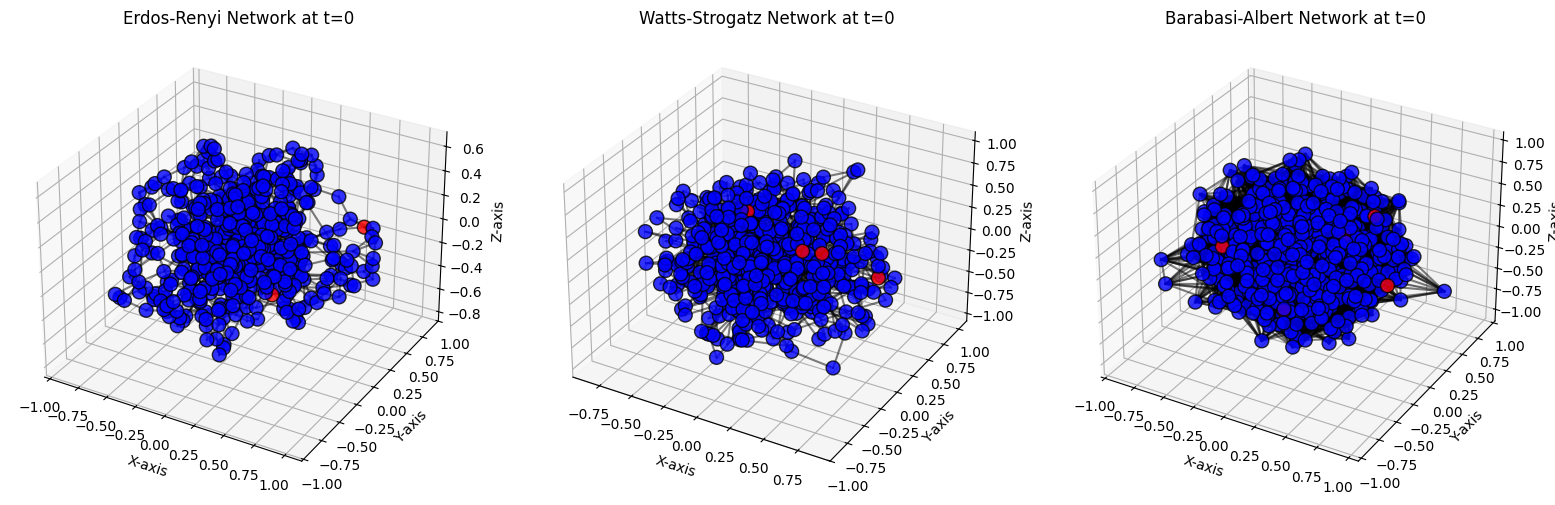

In [10]:
infected_nodes_lists = run_networks(networks, titles, beta, gamma, repetitions=20, num_iterations=50, fraction_infected=0.01, seed=None)
plot_all_networks_with_infected_nodes(networks, infected_nodes_lists)

In [15]:
import numpy as np
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

def run_sir_model_with_degree(network, beta, gamma, degree_k, num_iterations=50):
    # Create a new SIR model instance
    model = ep.SIRModel(network)
    cfg = mc.Configuration()
    
    # Set model parameters
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)

    # Get nodes with the specific degree k
    infected_nodes = [node for node in network.nodes if network.degree(node) == degree_k]

    # Create an initial status dictionary
    initial_status = {node: 0 for node in network.nodes}  # Set all to susceptible
    for node in infected_nodes:
        initial_status[node] = 1  # Set infected

    # Set the initial status in the model
    model.set_initial_status(initial_status)

    # Run the simulation
    model.set_initial_status(initial_status)
    iterations = model.iteration_bunch(num_iterations)

    # Extract data for plotting
    iters = [sim['iteration'] for sim in iterations]
    susceptible = [sim['node_count'][0] for sim in iterations]
    infected_counts = [sim['node_count'][1] for sim in iterations]
    recovered = [sim['node_count'][2] for sim in iterations]

    return iters, susceptible, infected_counts, recovered


def run_networks_with_degree(networks, beta, gamma, degree_k, repetitions, num_iterations=50, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility

    results = []
    
    for network in networks:
        # Initialize arrays to hold counts for averaging
        all_susceptible = np.zeros(num_iterations)
        all_infected = np.zeros(num_iterations)
        all_recovered = np.zeros(num_iterations)

        for _ in range(repetitions):
            # Run the SIR model for the current network with the specified degree k
            iterations, susceptible, infected, recovered = run_sir_model_with_degree(network, beta, gamma, degree_k, num_iterations)

            # Accumulate results
            all_susceptible += np.array(susceptible)
            all_infected += np.array(infected)
            all_recovered += np.array(recovered)

        # Average over repetitions
        avg_susceptible = all_susceptible / repetitions
        avg_infected = all_infected / repetitions
        avg_recovered = all_recovered / repetitions
        
        # Append results for the current network
        results.append((iterations, avg_susceptible, avg_infected, avg_recovered))

    return results


In [16]:
run_networks_with_degree(networks, 1, 1/6, 1, 50, 50, seed = None)


AttributeError: 'dict' object has no attribute 'get_model_parameters'

#### Dynamic Vaccination Campaign

In [230]:
# Step 1: Load the CSV file
df = pd. read_csv( 'transmission_network.csv', index_col=0, delimiter = ';')
df = df.map(lambda x: 1 if x != 0 else x)
# Convert all non-zero values to 1
# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(df.values)
# Print number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 374
Number of edges: 1265


In [231]:
def initial_infected_nodes(G, n=5, seed=None):
    if seed is not None:
        random.seed(seed)
    initial_infected = random.sample(list(G.nodes()), n)
    return initial_infected

initial_infected = initial_infected_nodes(G, 5, seed = 42)
print(initial_infected)

[327, 57, 12, 140, 125]


In [233]:


def run_sir_model(network, beta, gamma, initial_infected, num_iterations=50):
    # Create the model
    model = ep.SIRModel(network)
    
    # Create the configuration and add parameters (but no fraction_infected)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_initial_configuration('Infected', initial_infected)
    
    # Important: Do NOT reset the initial infected nodes here
    # The infected nodes have already been set manually in run_network
    model.set_initial_status(cfg)  # This now only sets up beta/gamma, not infection status
    
    # Run the simulation for the specified number of iterations
    simulations = model.iteration_bunch(num_iterations)
    
    # Extract simulation data: iterations, susceptible, infected, recovered
    iterations = [sim['iteration'] for sim in simulations]
    susceptible = [sim['node_count'][0] for sim in simulations]
    infected = [sim['node_count'][1] for sim in simulations]
    recovered = [sim['node_count'][2] for sim in simulations]
    
    return iterations, susceptible, infected, recovered

iterations, susceptible, infected, recovered = run_sir_model(G, 0.1, 0.3, initial_infected, num_iterations=50)
print(infected)

def get_sorted_degree_node_dict(network):
    # Create a dictionary to store degrees as keys and node indices as values
    degree_node_dict = {}

    # Iterate over all nodes in the network and their degrees
    for node, degree in network.degree():
        if network.has_node(node):  # Check if the node exists in the network
            if degree not in degree_node_dict:
                degree_node_dict[degree] = []  # Initialize list for this degree
            degree_node_dict[degree].append(node)  # Append node to the degree list
        else:
            print(f"Warning: The node {node} is not in the graph.")  # Log warning if node not found

    # Sort the dictionary by degree in descending order
    sorted_degree_node_dict = dict(sorted(degree_node_dict.items(), key=lambda item: item[0], reverse=True))

    return sorted_degree_node_dict

# Get the sorted degree-node dictionary
sorted_degree_node_dict = get_sorted_degree_node_dict(G)

# Print the sorted result
print(sorted_degree_node_dict)



[5, 9, 15, 25, 33, 48, 67, 76, 77, 77, 77, 58, 49, 39, 28, 21, 19, 19, 10, 9, 8, 8, 5, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
{20: [24], 15: [10, 25, 34, 63, 69, 87], 14: [58], 13: [0, 12, 33, 84, 90, 93], 12: [11, 21, 31, 37, 54, 56, 71, 76, 79], 11: [5, 15, 17, 36, 39, 52, 62, 77, 78], 10: [1, 4, 6, 16, 27, 30, 42, 44, 45, 50, 60, 80, 81, 99], 9: [7, 29, 32, 35, 53, 59, 65, 66, 67, 68, 70, 86, 97], 8: [2, 13, 22, 28, 41, 43, 48, 55, 72, 74, 83, 85, 88, 98], 7: [14, 40, 46, 47, 49, 57, 73, 75, 92, 94, 95, 96], 6: [3, 8, 9, 18, 19, 26, 51, 64, 82, 89, 91], 5: [20, 23, 38, 61]}


In [215]:
def run_network(network, beta, gamma, repetitions, num_iterations=50):
    # Set the seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    results = []
    model = ep.SIRModel(network)

    # Initialize arrays to store averages over repetitions
    all_susceptible = np.zeros(num_iterations)
    all_infected = np.zeros(num_iterations)
    all_recovered = np.zeros(num_iterations)

    for node in network.nodes():
        if model.status[node] == 1:
            print(node)

    for _ in range(repetitions):
        # Call the corrected run_sir_model without fraction_infected
        iterations, susceptible, infected, recovered = run_sir_model(
            network, beta, gamma, num_iterations
        )

        # Accumulate the results from this run
        all_susceptible += np.array(susceptible)
        all_infected += np.array(infected)
        all_recovered += np.array(recovered)

    # Averaging over repetitions
    avg_susceptible = all_susceptible / repetitions
    avg_infected = all_infected / repetitions
    avg_recovered = all_recovered / repetitions
    
    results.append((avg_susceptible, avg_infected, avg_recovered))
    
    # Return the results and infected nodes
    return results


In [218]:
seed = 42
results = run_network(G, 1, 1/6, 50, 50)
print(results)

TypeError: 'int' object is not iterable

In [223]:
def run_sir_model(network, beta, gamma, initial_infected, num_iterations=50):
    # Create the model
    model = ep.SIRModel(network)
    
    # Create the configuration and add parameters (but no fraction_infected)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_initial_configuration('Infected', initial_infected)
    
    # Set the initial status
    model.set_initial_status(cfg)
    
    # Run the simulation for the specified number of iterations
    simulations = model.iteration_bunch(num_iterations)
    
    # Extract simulation data: iterations, susceptible, infected, recovered
    iterations = [sim['iteration'] for sim in simulations]
    susceptible = [sim['node_count'][0] for sim in simulations]
    infected = [sim['node_count'][1] for sim in simulations]
    recovered = [sim['node_count'][2] for sim in simulations]
    
    return iterations, susceptible, infected, recovered

def run_network(network, beta, gamma, repetitions, num_iterations=50, initial_infected=None):
    # Set the seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    results = []
    model = ep.SIRModel(network)

    # Initialize arrays to store averages over repetitions
    all_susceptible = np.zeros(num_iterations)
    all_infected = np.zeros(num_iterations)
    all_recovered = np.zeros(num_iterations)

    if initial_infected is None:
        initial_infected = [random.choice(list(network.nodes()))]  # Randomly select an initial infected node if not provided

    print(f"Initial infected nodes: {initial_infected}")

    for _ in range(repetitions):
        # Call the corrected run_sir_model with initial_infected
        iterations, susceptible, infected, recovered = run_sir_model(
            network, beta, gamma, initial_infected, num_iterations
        )

        # Accumulate the results from this run
        all_susceptible += np.array(susceptible)
        all_infected += np.array(infected)
        all_recovered += np.array(recovered)

    # Averaging over repetitions
    avg_susceptible = all_susceptible / repetitions
    avg_infected = all_infected / repetitions
    avg_recovered = all_recovered / repetitions
    
    results.append((avg_susceptible, avg_infected, avg_recovered))
    
    # Return the results and infected nodes
    return results

# Example usage
seed = 42
results = run_network(G, 1, 1/6, 50, 1)



Initial infected nodes: [327]


#### Starting over

In [3]:
# Step 1: Load the CSV file
df = pd. read_csv( 'transmission_network.csv', index_col=0, delimiter = ';')
df = df.map(lambda x: 1 if x != 0 else x)
# Convert all non-zero values to 1
# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(df.values)
# Print number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 374
Number of edges: 1265


In [243]:
num_infected = 5
infected_nodes = random.sample(list(G.nodes), num_infected)

# Step 3: Print the indices of the infected nodes
print("Infected nodes:", infected_nodes)

Infected nodes: [145, 312, 338, 354, 358]


In [244]:
degree_node_dict = {}

# Step 3: Iterate over all nodes in the network and their degrees
for node, degree in G.degree():
    if degree not in degree_node_dict:
        degree_node_dict[degree] = []  # Initialize list for this degree if it doesn't exist
    degree_node_dict[degree].append(node)  # Append node to the list for this degree

# Step 4: Sort the dictionary by degree in descending order
sorted_degree_node_dict = dict(sorted(degree_node_dict.items(), key=lambda item: item[0], reverse=True))

# Step 5: Print the sorted dictionary
print(sorted_degree_node_dict)

{47: [20], 38: [87], 36: [76], 33: [66, 277], 28: [10], 27: [71], 26: [13], 25: [67], 24: [12, 105], 23: [8, 16, 35, 38, 83], 22: [178], 21: [289], 20: [26, 34, 78, 133, 313], 19: [9], 18: [90, 262], 17: [91, 166], 16: [93, 136, 186], 15: [5, 14, 30, 51, 79, 167, 221], 14: [29, 65, 316], 13: [11, 82, 100, 163, 196, 306], 12: [52, 85, 94, 99, 147, 164, 171, 174, 177, 187], 11: [58, 88, 130, 168, 185, 191, 278], 10: [1, 4, 17, 31, 56, 81, 138, 169, 170, 184, 197, 270, 284, 335], 9: [15, 18, 84, 92, 126, 141, 155, 165, 211, 251], 8: [0, 25, 28, 49, 60, 73, 75, 80, 89, 104, 154, 158, 180, 202, 216, 224, 230, 292, 339, 340, 345], 7: [3, 32, 40, 57, 59, 70, 72, 77, 108, 114, 127, 148, 152, 173, 188, 193, 207, 212, 215, 222, 241, 247, 253, 254, 267, 275, 287, 302, 307, 324, 325, 336, 368], 6: [42, 46, 53, 95, 101, 102, 110, 113, 119, 137, 150, 162, 189, 192, 204, 205, 213, 217, 248, 257, 264, 265, 276, 280, 288, 312, 331, 351, 354], 5: [2, 33, 39, 47, 69, 86, 103, 120, 121, 123, 145, 161, 183

#### Code that our friend made. I corrected most of it, but it doesnt count the vaccinated people at each iteration correctly.

In [4]:
import networkx as nx
import random
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
# Step 1: Load the transmission network
df = pd.read_csv('transmission_network.csv', index_col=0, delimiter=';')
df = df.map(lambda x: 1 if x != 0 else x)
G = nx.from_numpy_array(df.values)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 374
Number of edges: 1265


In [36]:
# Step 2: Randomly select 5 initial infected nodes with a seed for reproducibility
def select_initial_infected(G, num_initial_infected, seed=None):
    """Randomly selects a number of nodes to be initially infected from the network G."""
    if seed is not None:
        random.seed(seed)
    initial_infected = random.sample(list(G.nodes), num_initial_infected)
    
    # Print the selected nodes
    print(f"Selected {num_initial_infected} initial infected nodes: {initial_infected}")
    
    return initial_infected

initial_infected = select_initial_infected(G, 5, seed = 42)

Selected 5 initial infected nodes: [327, 57, 12, 140, 125]


In [43]:
# Function for dynamic testing strategy
def dynamic_testing(G, model_status, test_accuracy, max_tests_per_iteration, recovered_nodes):
    test_positive = []
    test_negative = []
    
    tests_in_current_iteration = 0
    # Sort nodes by degree, excluding recovered ones
    nodes_to_test = sorted((node for node in G.nodes if node not in recovered_nodes), 
                           key=lambda x: G.degree[x], reverse=True)
    
    # Loop through nodes in batches of 5 (highest degree first)
    for i in range(0, len(nodes_to_test), 5):
        top_5_nodes = nodes_to_test[i:i+5]
        
        local_positive = []
        for node in top_5_nodes:
            if tests_in_current_iteration >= max_tests_per_iteration:
                break
            # Check if node exists in model_status, assume susceptible (0) if not found
            node_status = model_status.get(node, 0)
            
            # Test this node: if infected (status = 1), simulate positive result with test_accuracy
            if node_status == 1:  # Infected
                if random.random() <= test_accuracy:
                    local_positive.append(node)
                    test_positive.append(node)
                else:
                    test_negative.append(node)
            else:  # Not infected (status 0)
                test_negative.append(node)
            tests_in_current_iteration += 1

        # If positive cases are found, test neighbors with remaining tests
        if local_positive:
            neighbors_to_test = []
            for node in local_positive:
                neighbors = sorted(G.neighbors(node), key=lambda x: G.degree[x], reverse=True)
                neighbors_to_test.extend([n for n in neighbors if n not in recovered_nodes])

            remaining_tests = max_tests_per_iteration - tests_in_current_iteration
            for neighbor in neighbors_to_test[:remaining_tests]:
                # Check neighbor status, assume susceptible if not found
                neighbor_status = model_status.get(neighbor, 0)
                
                if neighbor_status == 1:  # Infected
                    if random.random() <= test_accuracy:
                        test_positive.append(neighbor)
                    else:
                        test_negative.append(neighbor)
                else:
                    test_negative.append(neighbor)
                tests_in_current_iteration += 1
        
        if tests_in_current_iteration >= max_tests_per_iteration:
            break

    print(f"Tests taken: {tests_in_current_iteration}")
    return test_positive, test_negative

In [44]:
# Function for dynamic vaccination strategy with threshold
def dynamic_vaccination(G, model, vaccination_budget, infected_threshold, test_negative):
    vaccinated_nodes = []
    
    num_infected = sum(1 for status in model.status.values() if status == 1)
    
    if num_infected >= infected_threshold:  # Only vaccinate if threshold reached
        for node in test_negative:
            if vaccination_budget <= 0:
                break
            if model.status[node] == 0:  # Vaccinate only susceptible nodes
                model.status[node] = 2  # Move to recovered state
                vaccinated_nodes.append(node)
                vaccination_budget -= 1
    
    print(f"Vaccinated Nodes: {vaccinated_nodes}")
    return vaccinated_nodes

In [45]:
# Function to run the SIR model with testing and vaccination
def run_sir_model_with_testing_vaccination(network, beta, gamma, initial_infected, num_iterations, max_tests_per_iteration, test_accuracy, vaccination_budget, infected_threshold, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    model = ep.SIRModel(network)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_initial_configuration('Infected', initial_infected)
    model.set_initial_status(cfg)

    simulations = model.iteration_bunch(num_iterations)
    susceptible = [sim['node_count'][0] for sim in simulations]
    infected = [sim['node_count'][1] for sim in simulations]
    recovered = [sim['node_count'][2] for sim in simulations]
    
    vaccinated_over_time = [0] * num_iterations
    cumulative_vaccinated_nodes = set()

    for time_step, sim in enumerate(simulations):
        # We don't know who is infected, we discover by testing
        model_status = sim['status']

        # Dynamic testing
        test_positive, test_negative = dynamic_testing(network, model_status, test_accuracy, max_tests_per_iteration, cumulative_vaccinated_nodes)
        print(f"Test Positive: {test_positive}")

        # Dynamic vaccination
        new_vaccinated_nodes = dynamic_vaccination(network, model, vaccination_budget, infected_threshold, test_negative)
        cumulative_vaccinated_nodes.update(new_vaccinated_nodes)
        
        vaccinated_over_time[time_step] = len(cumulative_vaccinated_nodes)

        # Stop if no more infected people
        if sim['node_count'][1] == 0:
            print(f"All infections cleared at time step {time_step}.")
            break

    return susceptible, infected, recovered, vaccinated_over_time

In [46]:
# Function to plot S, I, R compartments and vaccinated individuals
def plot_sir_v(susceptible, infected, recovered, vaccinated, num_iterations):
    time = np.arange(num_iterations)
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, susceptible, label='Susceptible', color='blue')
    plt.plot(time, infected, label='Infected', color='red')
    plt.plot(time, recovered, label='Recovered', color='green')
    plt.plot(time, vaccinated, label='Vaccinated', color='purple', linestyle='--')
    
    plt.xlabel('Time (iterations)')
    plt.ylabel('Number of Individuals')
    plt.title('SIR Model with Vaccinations Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


Selected 5 initial infected nodes: [327, 57, 12, 140, 125]


100%|██████████| 50/50 [00:00<00:00, 2737.44it/s]

Tests taken: 10
Test Positive: [12]
Vaccinated Nodes: []
Tests taken: 10
Test Positive: [20, 13]
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: [87, 67]
Vaccinated Nodes: []
Tests taken: 10
Test Positive: [277]
Vaccinated Nodes: []
Tests taken: 10
Test Positive: [76, 66]
Vaccinated Nodes: []
Tests taken: 10
Test Positive: [71]
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccinated Nodes: []
Tests taken: 10
Test Positive: []
Vaccin

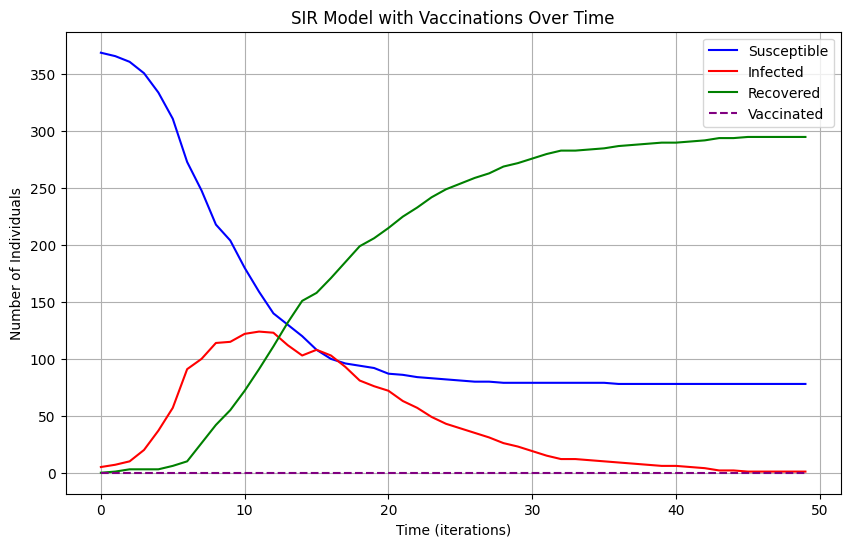

In [47]:
beta = 0.1
gamma = 1 / 7
test_accuracy = 0.75
vaccination_budget_per_step = 10
num_iterations = 50
num_initial_infected = 5
infected_threshold = 5
max_tests_per_iteration = 10
seed = 42

# Select initial infected nodes
initial_infected = select_initial_infected(G, num_initial_infected, seed=seed)

# Run the SIR model with testing and vaccination
susceptible, infected, recovered, vaccinated_over_time = run_sir_model_with_testing_vaccination(
    G, beta, gamma, initial_infected, num_iterations, max_tests_per_iteration, test_accuracy, vaccination_budget_per_step, infected_threshold, seed=seed
)

# Plot the results
plot_sir_v(susceptible, infected, recovered, vaccinated_over_time, num_iterations)